In [1]:
import wandb
import pandas as pd
import os
import shutil
import json
import pickle
import seaborn as sns
import re
import numpy as np

from matplotlib import pyplot as plt

In [2]:
config_of_interest = {
    'regime': lambda x: x['train'], 
    'dataset': lambda x: "KANDY_2" if x['use_global_concepts'] else "KANDY_1", 
    'model': lambda x: x['model'], 
    'triplet_lambda': lambda x: x['triplet_lambda'],
    'concept_intersection': lambda x: x['use_mask'] if x['triplet_lambda'] > 0. else "no",
    'hamming_margin': lambda x: 0 if x['triplet_lambda'] == 0. else x['hamming_margin'], 
    'replay_lambda': lambda x: x['replay_lambda'], 
    'concept_normalization': lambda x: "no" if not x['decorrelate_concepts'] else ("bn" if x['decorrelation_groups'] == 1 else "dbn")
    }
series_of_interest = ['avg_accuracy-val', 'avg_accuracy-test', 'avg_forgetting-test', 'backward_transfer-test',
                      'cas-val', 'cas-test', 'cas_extended-val', 'cas_extended-test', 'ccs-test', 'ccs_extended-test', 
                      'cvs-test', 'cvs_extended-test', 'forward_transfer-test', 'tas-test', 'tas_extended-test', 
                      'tcs-test', 'tcs_extended-test', 'tvs-test', 'tvs_extended-test']
 
matrices_of_interest = ['concept_correlation_phi_pp_continual-tab-test', 
                      'concept_correlation_phi_pp_continual_extended-tab-test', 'concept_correlation_phi_pt_continual-tab-test', 
                      'concept_correlation_phi_pt_continual_extended-tab-test']

downloads_of_interest = ['acc_matrix-test', 'acc_matrix-val', 'concept_correlation_phi_pt-test-fig', 
                         'concept_correlation_phi_tt-test-fig', 'concept_correlation_phi_pp-test-fig',
                         'concept_correlation_phi_pt_continual_extended-train', 'concept_correlation_phi_pt_continual_extended-val', 
                         'concept_correlation_phi_pt_continual_extended-test']


def config_to_string(cfg):
    opts = [v(cfg) for v in config_of_interest.values()]
    return "{}-{}-{}-t{}-{}-h{}-r{}-{}".format(*opts)

def get_history(run):
    out = {}
    max_task_id = 0
    counting_k = None
    for cfg, v in config_of_interest.items():
        out[cfg] = v(run.config)
    for log in run.scan_history():
        for k in matrices_of_interest:
            if log[k] is not None:
                out[k] = log[k]
        for k in downloads_of_interest:
            if log[k] is not None:
                out[k] = log[k]
        for k in series_of_interest:
            if log[k] is not None:
                if k not in out:
                    out[k] = []
                    if counting_k is None:
                        counting_k = k
                out[k].append(log[k])
                if counting_k == k:
                    max_task_id += 1
    for k in series_of_interest:
        out[k] = pd.Series(out[k])
    return out, max_task_id

def download_files(run, name, history):
    os.makedirs("data/{}".format(name), exist_ok=True)
    for k in downloads_of_interest:
        print("Downloading {}/{}".format(name, k))
        run.file(history[k]["path"]).download(exist_ok=True)
        ext = history[k]["path"].split(".")[-1]
        shutil.move(history[k]["path"], "data/{}/{}.{}".format(name, k, ext))
        history[k] = "data/{}/{}.{}".format(name, k, ext)

    return history

def build_matrices(history, n_tasks, joint=False):
    for k, v in history.items():
        if k in matrices_of_interest:
            tmp = []
            if not joint:
                for i in range(n_tasks):
                    tmp.append(pd.DataFrame(
                        v[i]["data"],
                        index=v[i]["x_label"],
                        columns=v[i]["y_label"]
                    ))
            else:
                tmp.append(pd.DataFrame(
                        v[0]["data"],
                        index=v[0]["x_label"],
                        columns=v[0]["y_label"]
                    ))
            history[k] = pd.Series(tmp)
        if k in downloads_of_interest and k.startswith("acc_matrix"):
            with open(history[k]) as file:
                tmp = json.load(file)
            col = tmp["columns"][1:]
            rows = []
            data = []
            for r in tmp["data"]:
                rows.append(r[0])
                data.append(r[1:])
            
            history[k] = pd.DataFrame(data, index=rows, columns=col)
    return history

os.makedirs("data", exist_ok=True)


In [3]:
if os.path.exists("models.pkl"):
    with open("models.pkl", "rb") as file:
        models = pickle.load(file)
else:

    api = wandb.Api()
    sweeps = ["l-lorello/kandy-cem-experiments/hsp0mjp6", "l-lorello/kandy-cem-experiments/eafdwfzq", 
              "l-lorello/kandy-cem-experiments/fq3hi0qu","l-lorello/kandy-cem-experiments/k11az40k"]
    
    models = {}
    for s in sweeps:
        sweep = api.sweep(s)
        for r in sweep.runs:
            name = config_to_string(r.config)
            if name not in models:
                try:
                    print("Importing data from configuration {}".format(name))
                    history, n_tasks = get_history(r)
                    history = download_files(r, name, history)
                    history = build_matrices(history, n_tasks, joint=r.config["train"] == "joint")
                    models[name] = history
                except Exception as e:
                    print(e)
                    #print("Missing data. Skipping run (probably crashed).")
    
    with open("models.pkl", "wb") as file:
        pickle.dump(models, file)

def diagonalization_metric(model):
    out = []
    for pp in model["concept_correlation_phi_pp_continual-tab-test"]:
        score = np.abs(pp.to_numpy())
        score = score * (np.ones_like(pp, dtype=float) - np.eye(pp.shape[0], dtype=float))
        score = 1. - score.mean()
        out.append(score)
    out_ext = []
    for pp in model["concept_correlation_phi_pp_continual_extended-tab-test"]:
        score = np.abs(pp.to_numpy())
        score = score * (np.ones_like(pp, dtype=float) - np.eye(pp.shape[0], dtype=float))
        score = 1. - score.mean()
        out_ext.append(score)
    
    return pd.Series(out), pd.Series(out_ext)

def jsd(model):
    pos = []
    neg = []
    out = []
    
    for mat in model["concept_correlation_phi_pt_continual-tab-test"]:
        pt = mat.to_numpy()
        m_pos = np.where(pt > 0, pt, 0)
        for i in range(m_pos.shape[0]):
            if m_pos[i].sum() > 0:
                m_pos[i] /= m_pos[i].sum()
        
        m_neg = -np.where(pt < 0, pt, 0) 
        for i in range(m_neg.shape[0]):
            if m_neg[i].sum() > 0:
                m_neg[i] /= m_neg[i].sum()
        
        q = np.zeros_like(pt)
        q_neg = np.zeros_like(pt)
        for i in range(q.shape[0]):
            j = np.argmax(m_pos[i])
            if np.max(m_pos[i]) != 0:
                q[i,j] = 1.
            j = np.argmax(m_neg[i])
            if np.max(m_neg[i]) != 0:
                q_neg[i,j] = 1.
        
        kld_q = np.multiply(m_pos, np.log((m_pos + 1e-6) / (q + 1e-6))).sum(axis=0).mean()
        kld_q += np.multiply(q, np.log((q + 1e-6) / (m_pos + 1e-6))).sum(axis=0).mean()
        kld_q /= 2
        
        kld_q_neg = np.multiply(m_neg, np.log((m_neg + 1e-6) / (q_neg + 1e-6))).sum(axis=0).mean()
        kld_q_neg += np.multiply(q_neg, np.log((q_neg + 1e-6) /(m_neg + 1e-6))).sum(axis=0).mean()
        kld = (kld_q + kld_q_neg) / 2

        pos.append(kld_q)
        neg.append(kld_q_neg)
        out.append(kld)
        
    pos_ext = []
    neg_ext = []
    out_ext = []
    
    for mat in model["concept_correlation_phi_pt_continual_extended-tab-test"]:
        pt = mat.to_numpy()
        m_pos = np.where(pt > 0, pt, 0)
        for i in range(m_pos.shape[0]):
            if m_pos[i].sum() > 0:
                m_pos[i] /= m_pos[i].sum()
        
        m_neg = -np.where(pt < 0, pt, 0) 
        for i in range(m_neg.shape[0]):
            if m_neg[i].sum() > 0:
                m_neg[i] /= m_neg[i].sum()
        
        q = np.zeros_like(pt)
        q_neg = np.zeros_like(pt)
        for i in range(q.shape[0]):
            j = np.argmax(m_pos[i])
            if np.max(m_pos[i]) != 0:
                q[i,j] = 1.
            j = np.argmax(m_neg[i])
            if np.max(m_neg[i]) != 0:
                q_neg[i,j] = 1.
        
        kld_q = np.multiply(m_pos, np.log((m_pos + 1e-6) / (q + 1e-6))).sum(axis=0).mean()
        kld_q += np.multiply(q, np.log((q + 1e-6) / (m_pos + 1e-6))).sum(axis=0).mean()
        kld_q /= 2
        
        kld_q_neg = np.multiply(m_neg, np.log((m_neg + 1e-6) / (q_neg + 1e-6))).sum(axis=0).mean()
        kld_q_neg += np.multiply(q_neg, np.log((q_neg + 1e-6) /(m_neg + 1e-6))).sum(axis=0).mean()
        kld = (kld_q + kld_q_neg) / 2

        pos_ext.append(kld_q)
        neg_ext.append(kld_q_neg)
        out_ext.append(kld)
    return pd.Series(pos), pd.Series(neg), pd.Series(out), pd.Series(pos_ext), pd.Series(neg_ext), pd.Series(out_ext)

for k, v in models.items():
    models[k]["diagonalized-test"], models[k]["diagonalized_extended-test"] = diagonalization_metric(v)
    models[k]["jsd_p-test"], models[k]["jsd_n-test"], models[k]["jsd-test"], models[k]["jsd_p_extended-test"], models[k]["jsd_n_extended-test"], models[k]["jsd_extended-test"] = jsd(v)


In [4]:
best_models = {}
best_models["KANDY_1"] = {
    "cnn": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}}, 
    "resnet50_head_only": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}},
    "vit_head_only": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}}
}

best_models["KANDY_2"] = {
    "cnn": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}}, 
    "resnet50_head_only": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}},
    "vit_head_only": {"continual_task": {"triplet": None, "simple": None}, "joint": {"triplet": None, "simple": None}}
}


for k, v in models.items():
    model = v["model"]
    regime = v["regime"]
    dataset = v["dataset"]
    triplet = "triplet" if v["triplet_lambda"] > 0 else "simple"

    if v["concept_intersection"] == "no" and v["concept_normalization"] == "no":
        if best_models[dataset][model][regime][triplet] is None:
            best_models[dataset][model][regime][triplet] = k
    
        if regime == "joint":
            if v["avg_accuracy-val"][0] > models[best_models[dataset][model][regime][triplet]]["avg_accuracy-val"][0]:
                best_models[dataset][model][regime][triplet] = k
        else:
            if v["avg_accuracy-val"].iloc[-1] > models[best_models[dataset][model][regime][triplet]]["avg_accuracy-val"].iloc[-1]: # TODO: cambiare
                best_models[dataset][model][regime][triplet] = k

print(best_models)

{'KANDY_1': {'cnn': {'continual_task': {'triplet': 'continual_task-KANDY_1-cnn-t1-no-h4-r1-no', 'simple': 'continual_task-KANDY_1-cnn-t0-no-h0-r1-no'}, 'joint': {'triplet': 'joint-KANDY_1-cnn-t1-no-h1-r0-no', 'simple': 'joint-KANDY_1-cnn-t0-no-h0-r0-no'}}, 'resnet50_head_only': {'continual_task': {'triplet': 'continual_task-KANDY_1-resnet50_head_only-t10-no-h1-r10-no', 'simple': 'continual_task-KANDY_1-resnet50_head_only-t0-no-h0-r10-no'}, 'joint': {'triplet': 'joint-KANDY_1-resnet50_head_only-t1-no-h1-r0-no', 'simple': 'joint-KANDY_1-resnet50_head_only-t0-no-h0-r0-no'}}, 'vit_head_only': {'continual_task': {'triplet': 'continual_task-KANDY_1-vit_head_only-t1-no-h4-r10-no', 'simple': 'continual_task-KANDY_1-vit_head_only-t0-no-h0-r1-no'}, 'joint': {'triplet': 'joint-KANDY_1-vit_head_only-t1-no-h4-r0-no', 'simple': 'joint-KANDY_1-vit_head_only-t0-no-h0-r0-no'}}}, 'KANDY_2': {'cnn': {'continual_task': {'triplet': 'continual_task-KANDY_2-cnn-t1-no-h1-r1-no', 'simple': 'continual_task-KAND

In [5]:
metrics_of_interest = ['avg_accuracy-test', 'avg_forgetting-test', 'backward_transfer-test',
          'cas_extended-test', 'forward_transfer-test', 'tas_extended-test', 
          'diagonalized-test', 'jsd_p-test', 'jsd_n-test', 'jsd-test',
          'diagonalized_extended-test', 'jsd_p_extended-test', 'jsd_n_extended-test', 'jsd_extended-test']

header = [x.split("-")[0].replace("_", " ").title() for x in metrics_of_interest]


for dataset, v in best_models.items():
    print("\\begin{table}")
    print("\\centering")
    print("\\adjustbox{max width=1\\textheight, angle=90}{")
    print("\\begin{tabular}{c|" + "c" * len(header) + "}")
    print("\\toprule")
    print("Model & " + " & ".join(header) + " \\\\")
    for model, v2 in v.items():
        print("\\midrule")
        print("\\multicolumn{" + str(len(header) + 1) + "}{c}{" + model.replace("_", "\\_") + "}\\\\")
        for regime, v3 in v2.items():
            print("\\multicolumn{" + str(len(header) + 1) + "}{c}{" + regime.replace("_", "\\_") + "}\\\\")
            for v4 in v3.values():
                name = "$\\lambda_t = {}, \\lambda_r = {}, H_m = {}$".format(models[v4]["triplet_lambda"], models[v4]["replay_lambda"], models[v4]["hamming_margin"])
                print_list = ["{:.2f}".format(models[v4][metric].iloc[-1]) for metric in metrics_of_interest if metric.endswith("-test")]
                print("{} & {} \\\\".format(name, " & ".join(print_list)))
    print("\\bottomrule")
    print("\\end{tabular}")
    print("}")
    print("\\caption{" + dataset.replace("_", " ") + "}")
    print("\\end{table}")

\begin{table}
\centering
\adjustbox{max width=1\textheight, angle=90}{
\begin{tabular}{c|cccccccccccccc}
\toprule
Model & Avg Accuracy & Avg Forgetting & Backward Transfer & Cas Extended & Forward Transfer & Tas Extended & Diagonalized & Jsd P & Jsd N & Jsd & Diagonalized Extended & Jsd P Extended & Jsd N Extended & Jsd Extended \\
\midrule
\multicolumn{15}{c}{cnn}\\
\multicolumn{15}{c}{continual\_task}\\
$\lambda_t = 1.0, \lambda_r = 1.0, H_m = 4$ & 0.66 & 0.15 & 0.00 & 0.59 & 0.02 & 0.79 & 0.67 & 9.30 & 16.72 & 13.01 & 0.61 & 6.60 & 23.21 & 14.90 \\
$\lambda_t = 0.0, \lambda_r = 1.0, H_m = 0$ & 0.69 & 0.15 & 0.00 & 0.60 & 0.00 & 0.79 & 0.88 & 7.92 & 16.52 & 12.22 & 0.84 & 7.83 & 22.82 & 15.32 \\
\multicolumn{15}{c}{joint}\\
$\lambda_t = 1.0, \lambda_r = 0.0, H_m = 1$ & 0.62 & 0.00 & 0.00 & 0.71 & 0.11 & 0.70 & 0.31 & 10.03 & 16.24 & 13.14 & 0.28 & 9.56 & 18.00 & 13.78 \\
$\lambda_t = 0.0, \lambda_r = 0.0, H_m = 0$ & 0.72 & 0.00 & 0.00 & 0.70 & 0.20 & 0.76 & 0.69 & 8.78 & 18.01 & 13.4

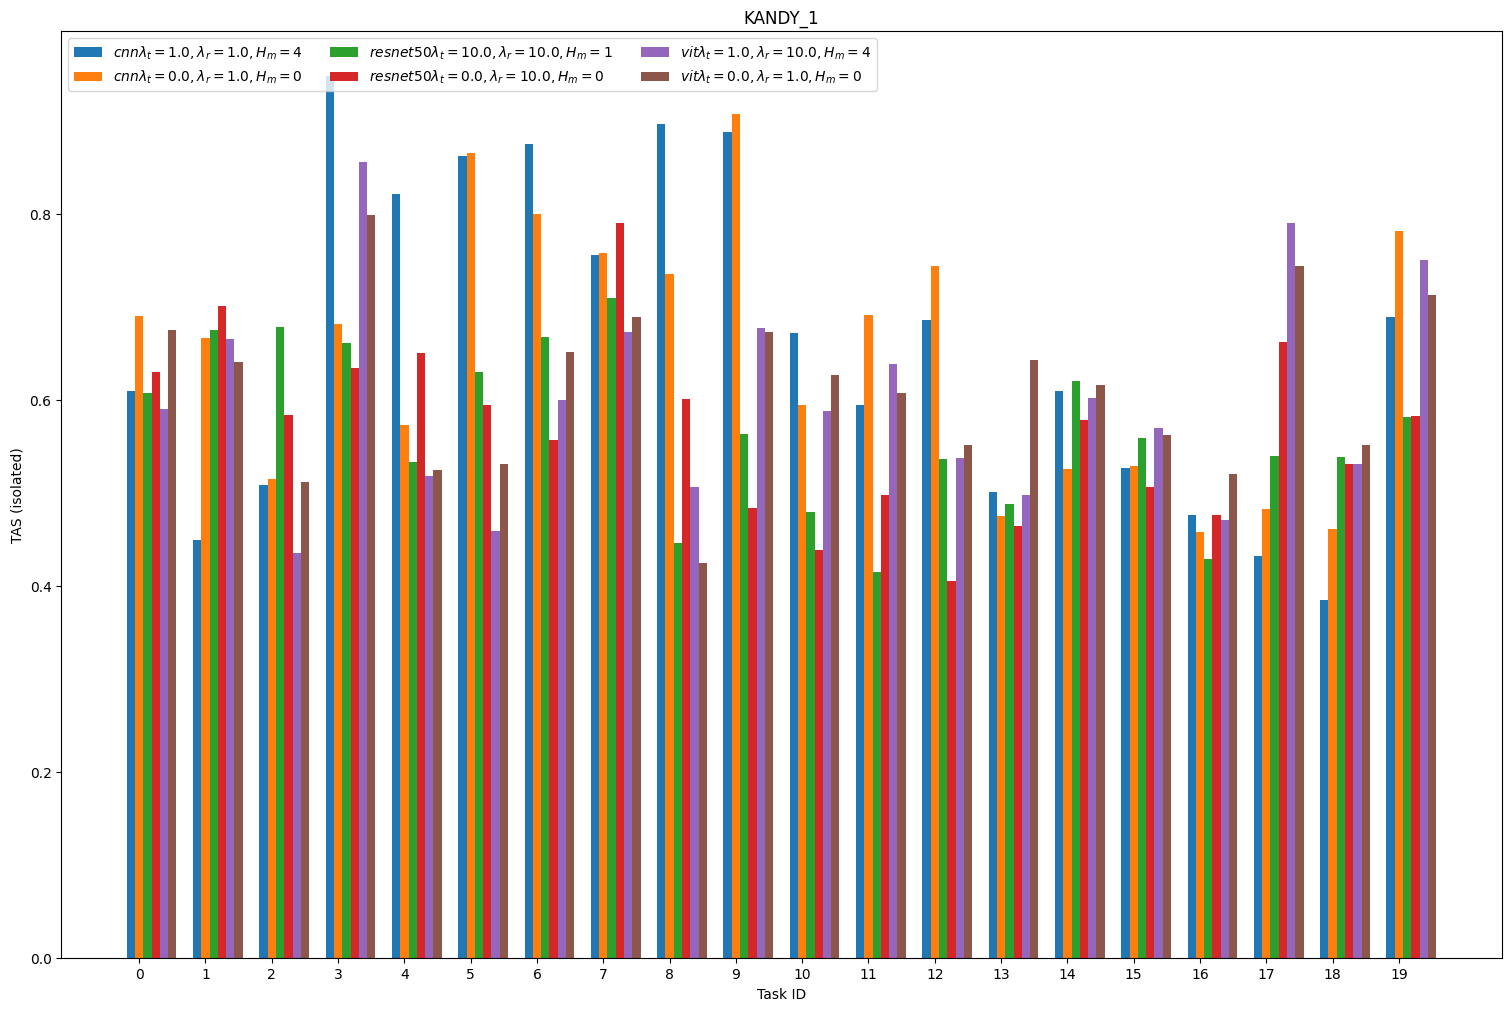

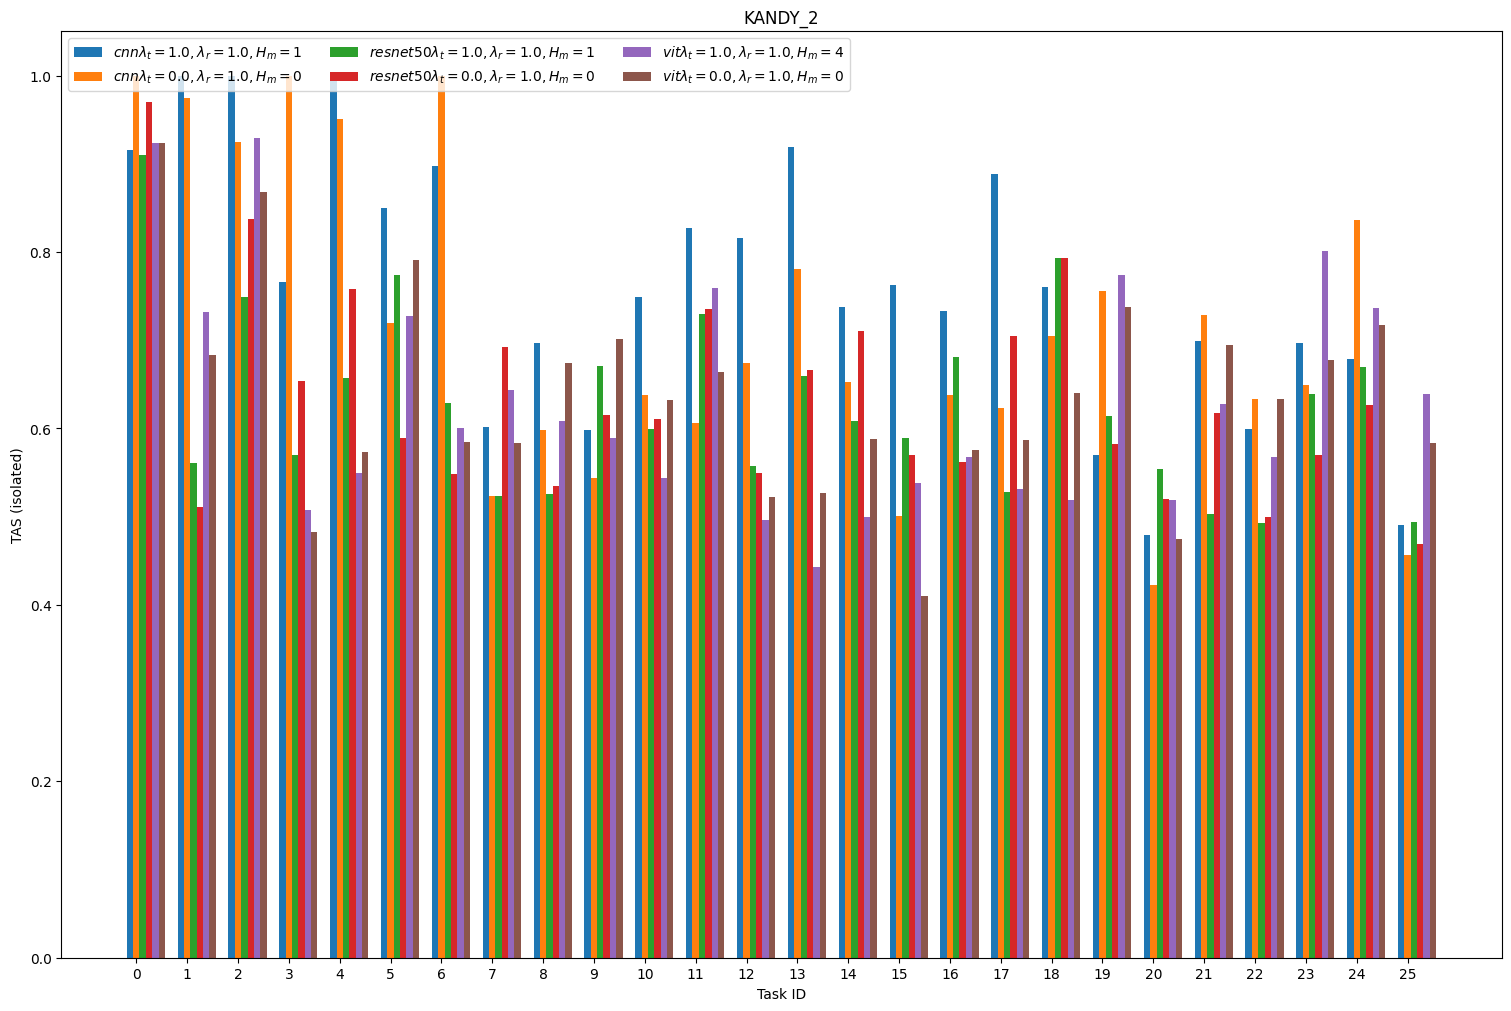

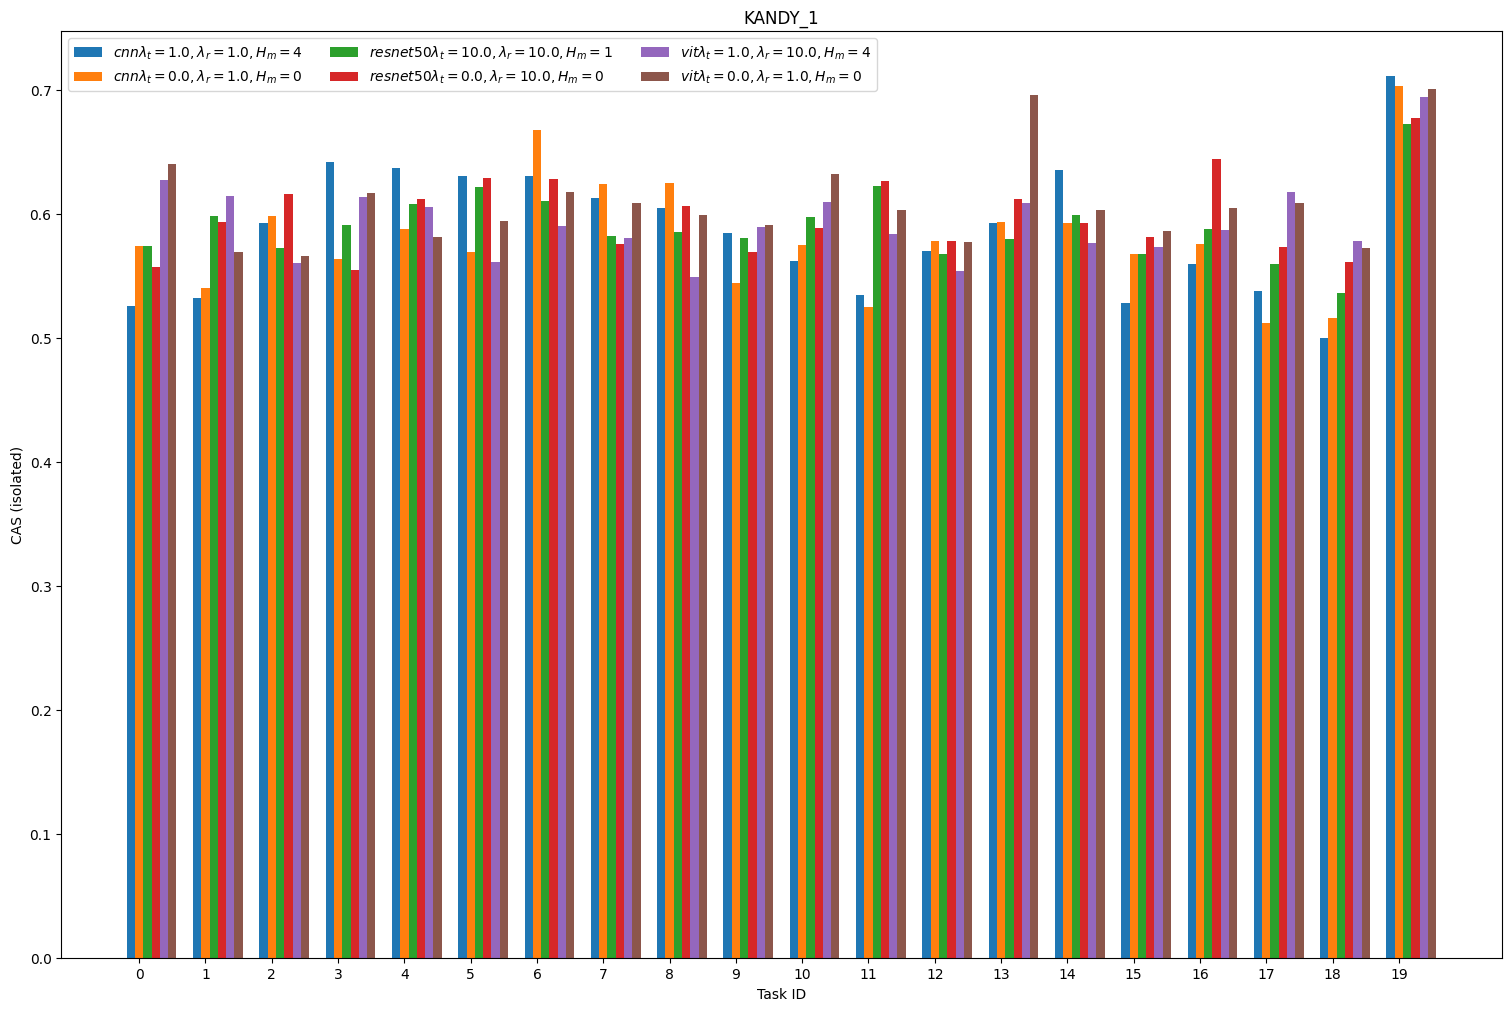

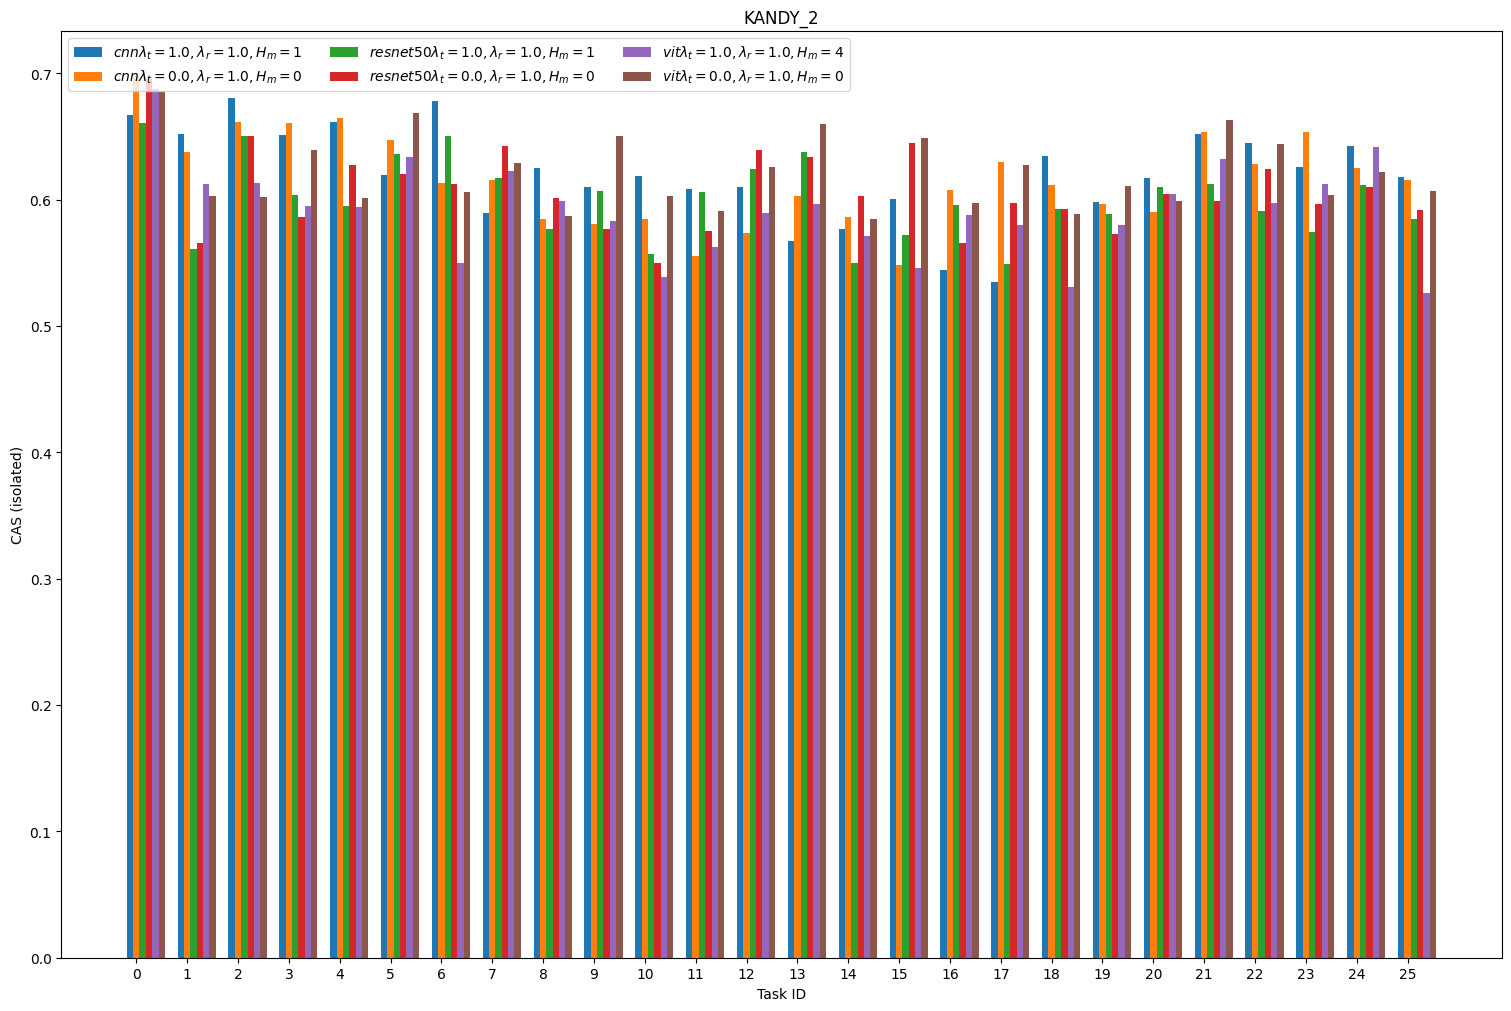

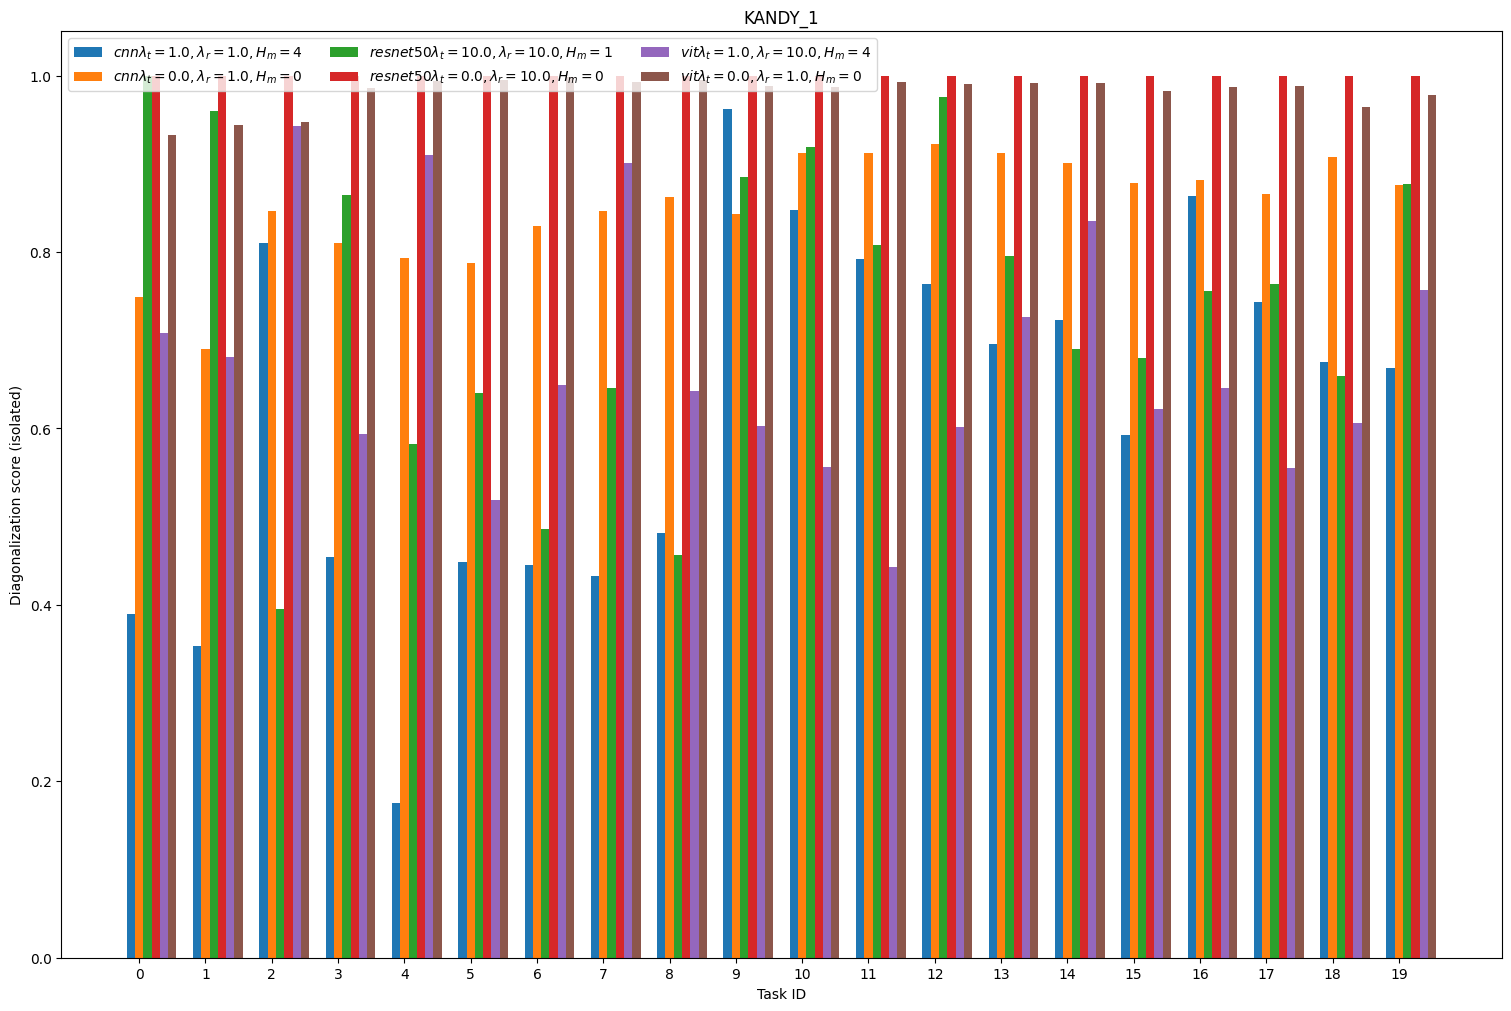

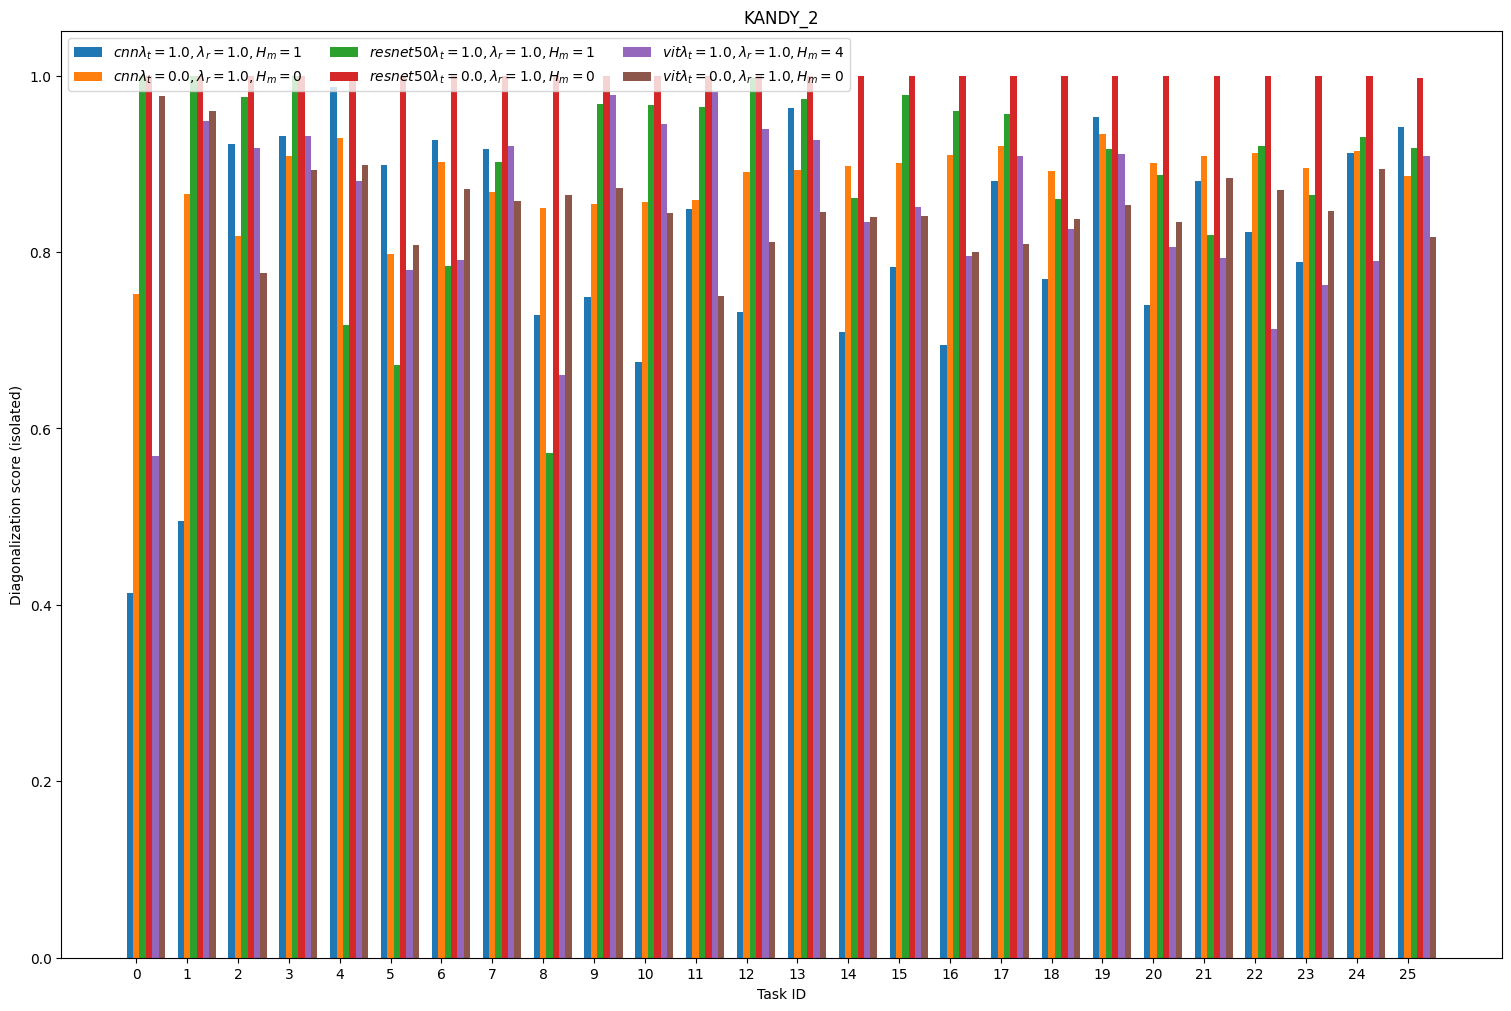

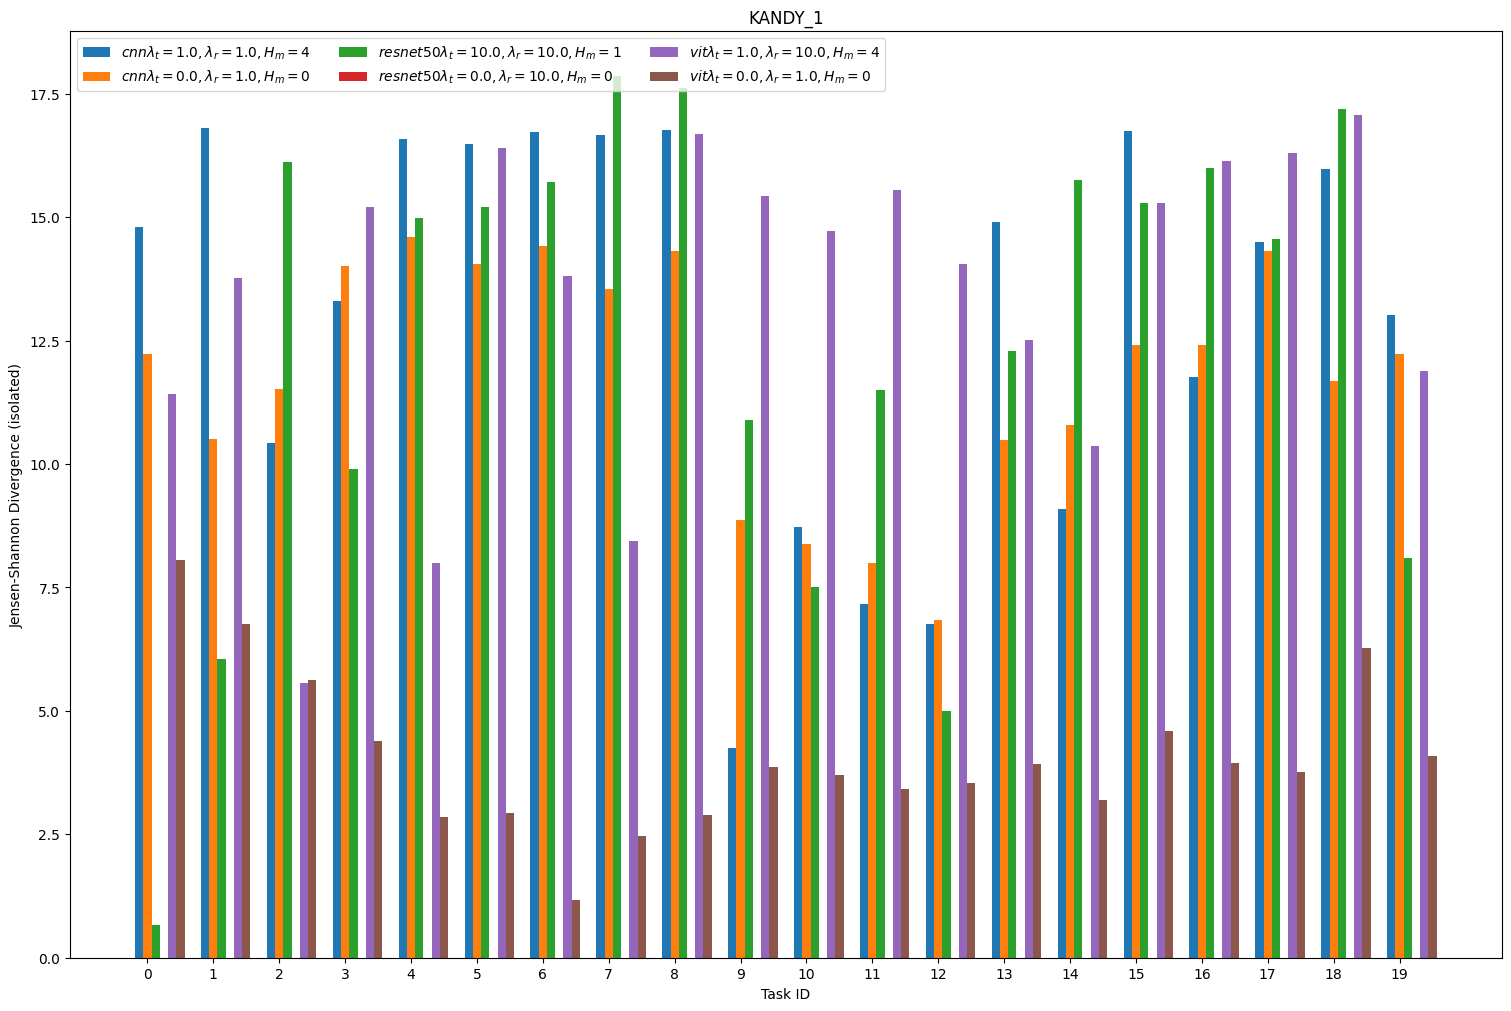

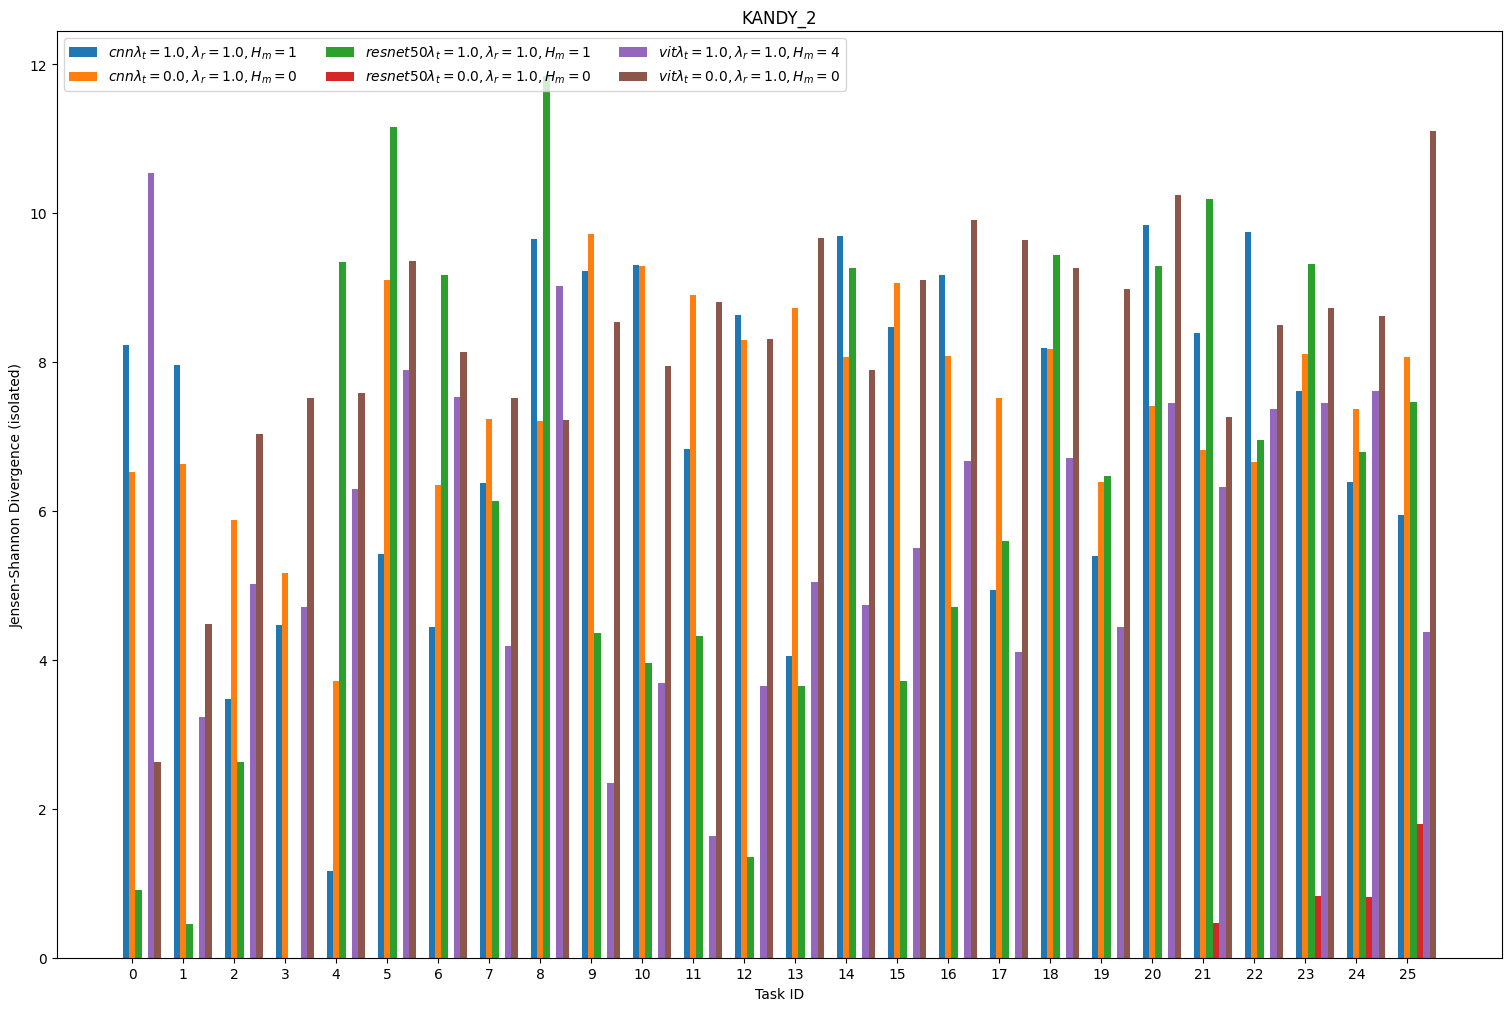

In [6]:
# BARPLOTS

# Caveat: se la JSD ha denominatore 0 per un task, la sua barra è 0 (dovrebbe essere a "infinito", ma è bene che nella visualizzazione non ci sia)

metrics_to_plot = {"TAS (isolated)": "tas-test", "CAS (isolated)": "cas-test", "Diagonalization score (isolated)": "diagonalized-test", "Jensen-Shannon Divergence (isolated)": "jsd-test"}

for metric_name, metric_key in metrics_to_plot.items():
    for dataset, v in best_models.items():
        task_ids = None
        values = {}
        for model, v2 in v.items():
            for triplet, v3 in v2["continual_task"].items():
                m = models[v3]
                name = "${} \\lambda_t={},\\lambda_r={},H_m={}$".format(model.split("_")[0], m["triplet_lambda"], m["replay_lambda"], m["hamming_margin"])
                
                values[name] = []
                
                if task_ids is None:
                    task_ids = list(range(len(m[metric_key])))
                for i in task_ids:
                    values[name].append(m[metric_key].iloc[i])
    
        x = np.arange(len(task_ids))  # the label locations
        width = 1 / (len(values.keys()) + 2)  # the width of the bars
        multiplier = 0
        fig, ax = plt.subplots(figsize=(15,10), layout='constrained')
        
        for n, val in values.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, val, width, label=n)
            #ax.bar_label(rects, padding=3)
            multiplier += 1
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Task ID')
        ax.set_title(dataset)
        ax.set_xticks(x + width, task_ids)
        ax.legend(loc='upper left', ncols=3)
        
        plt.show()


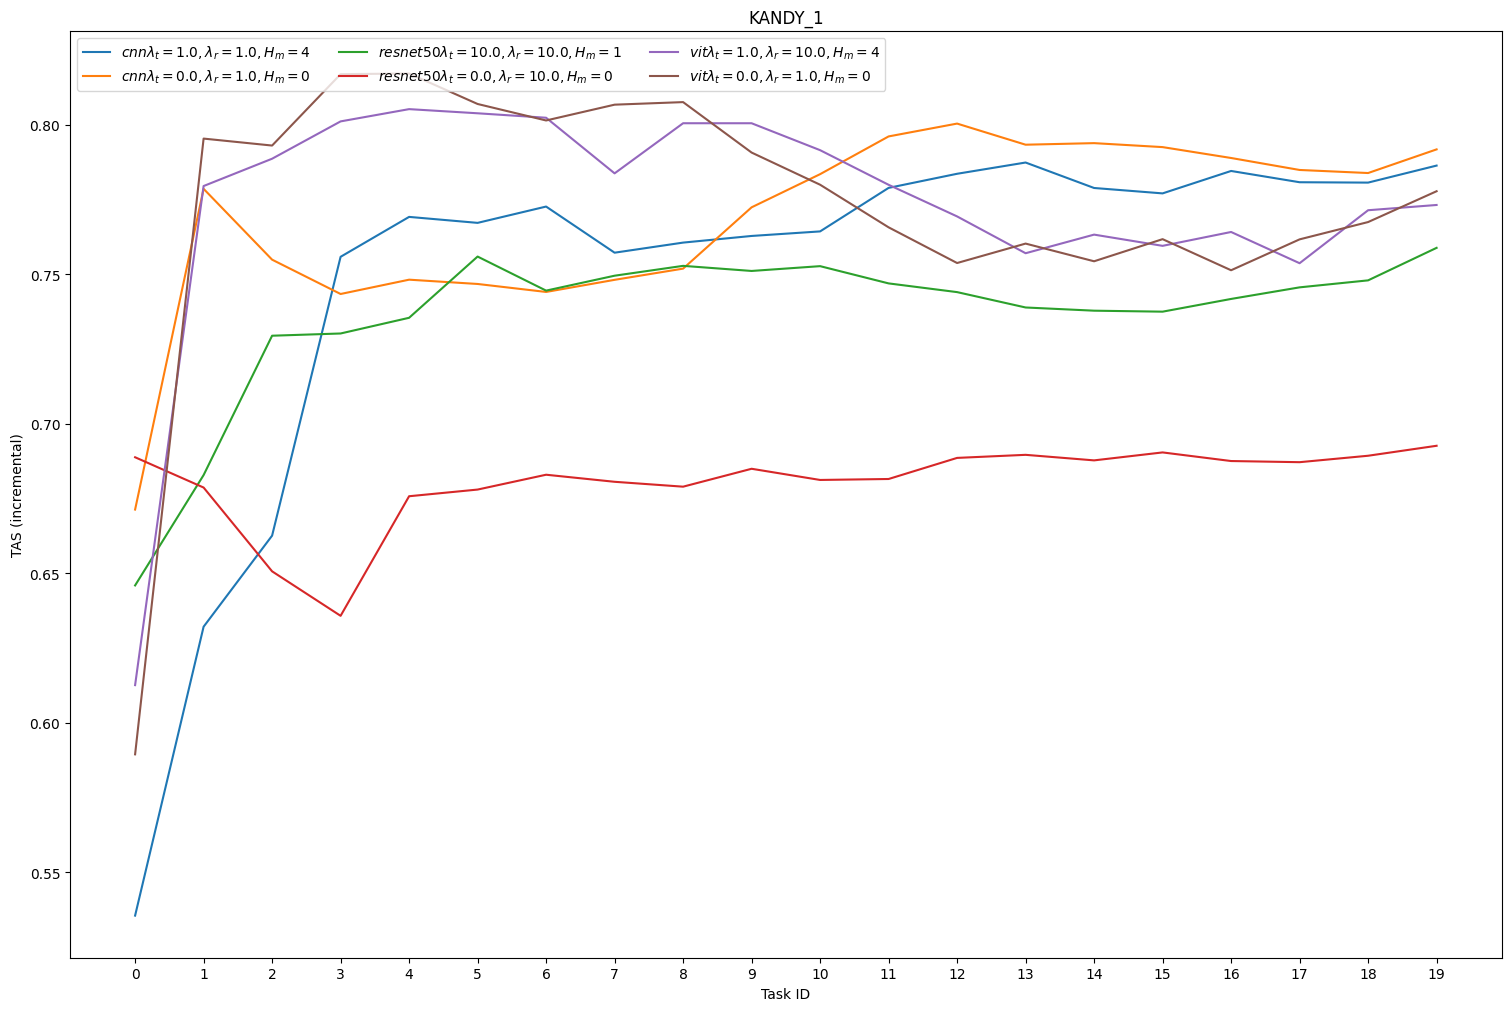

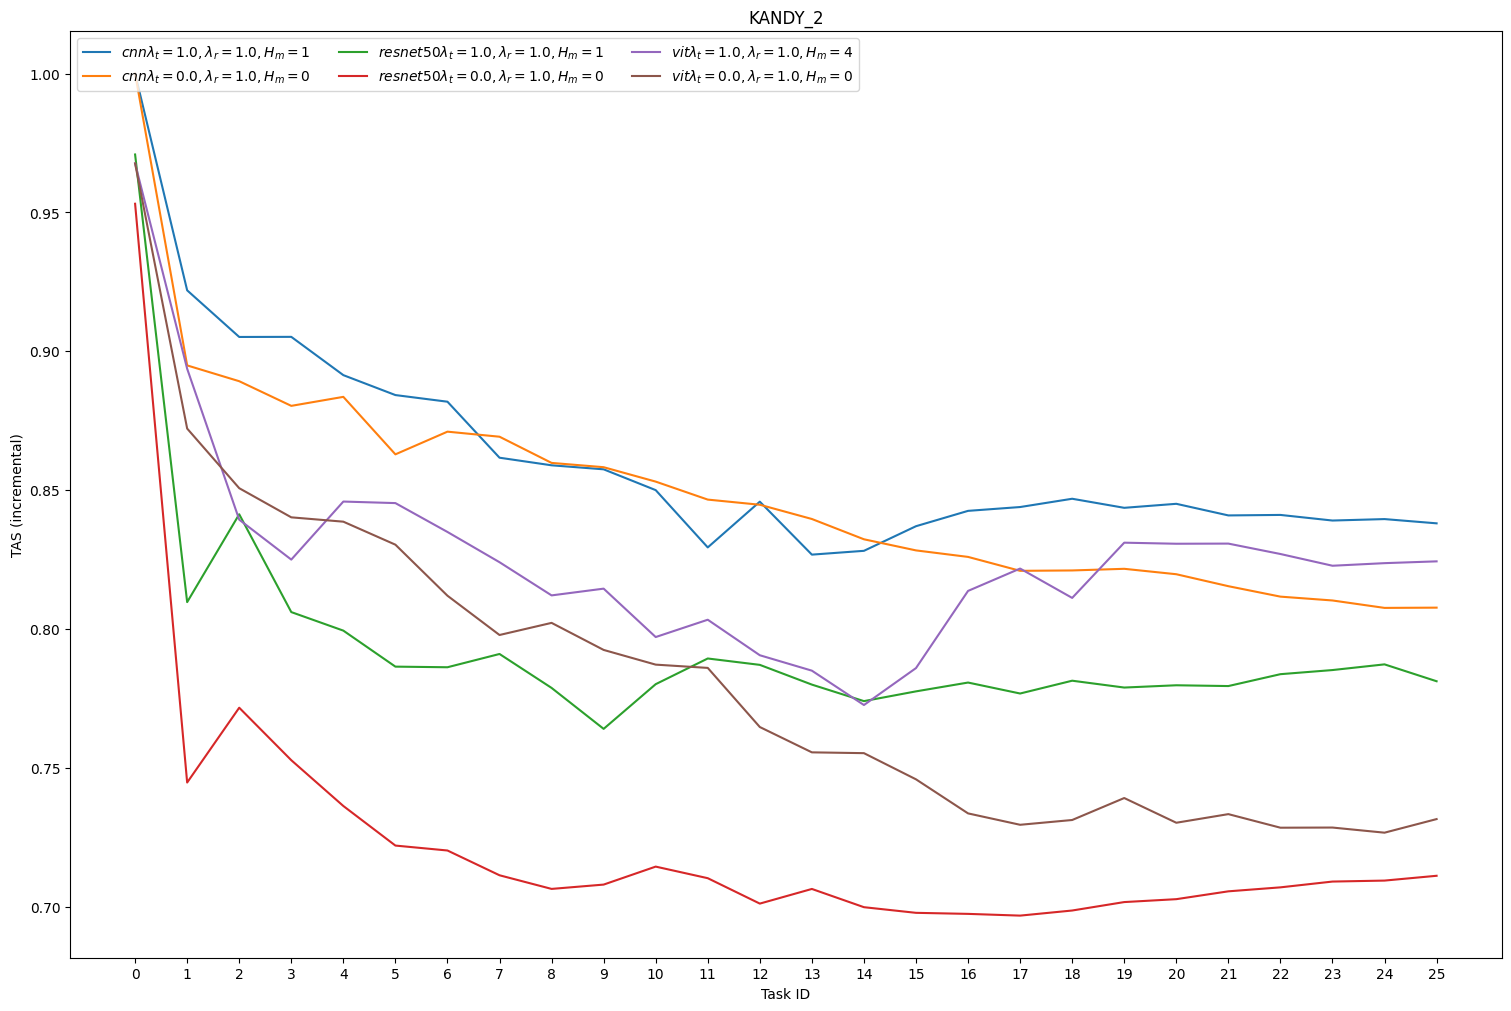

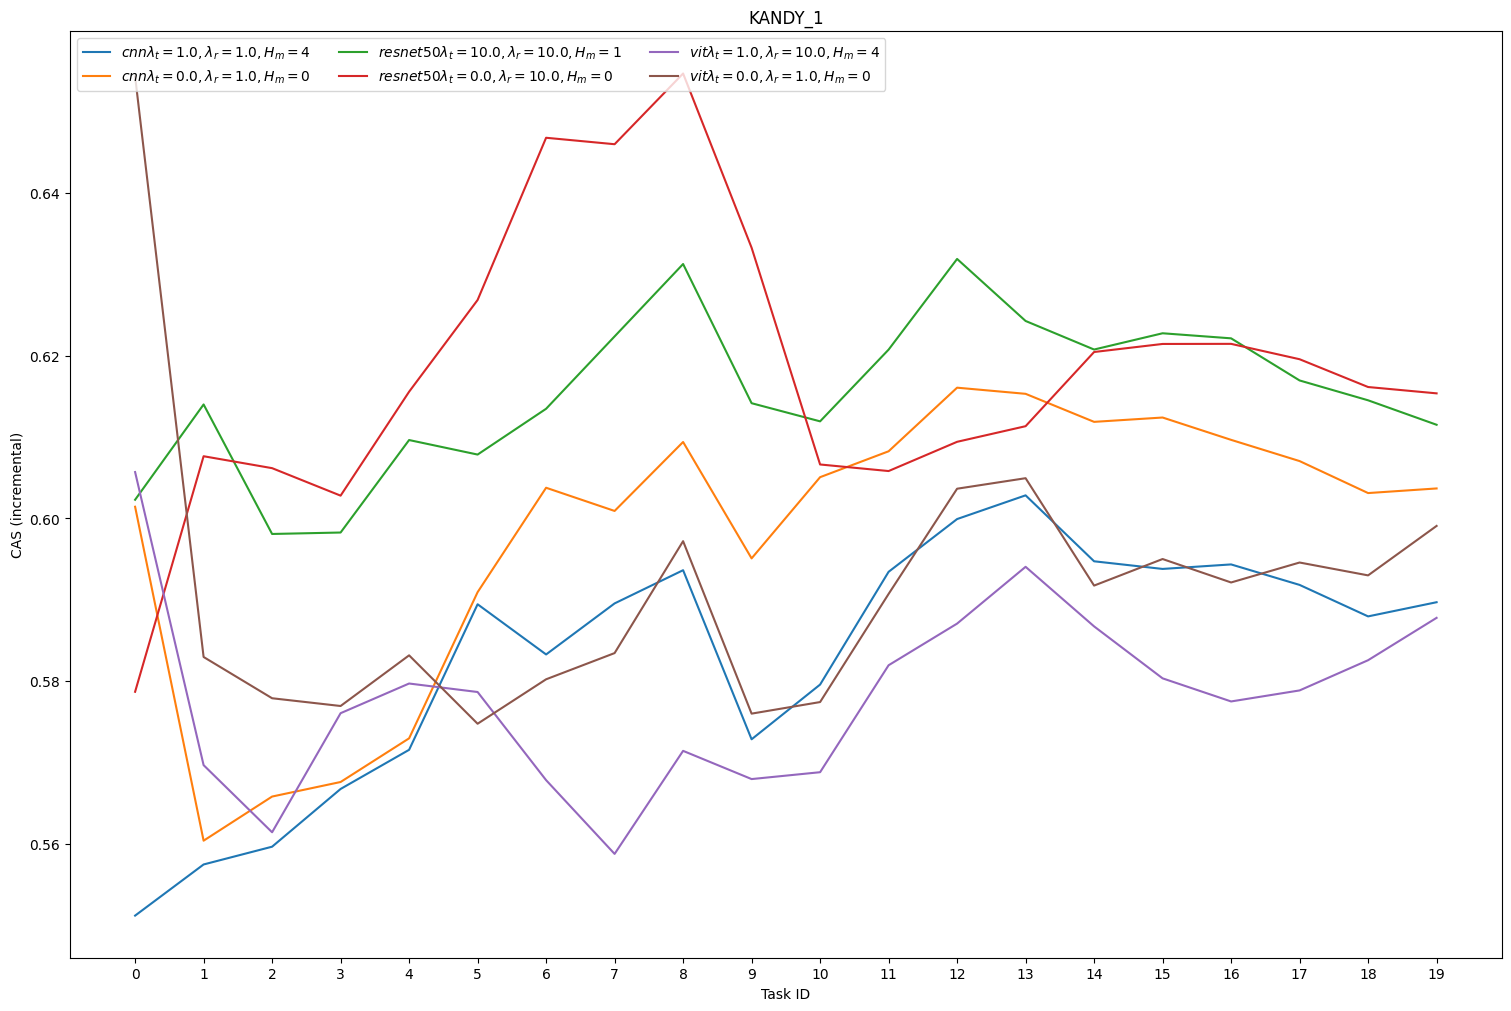

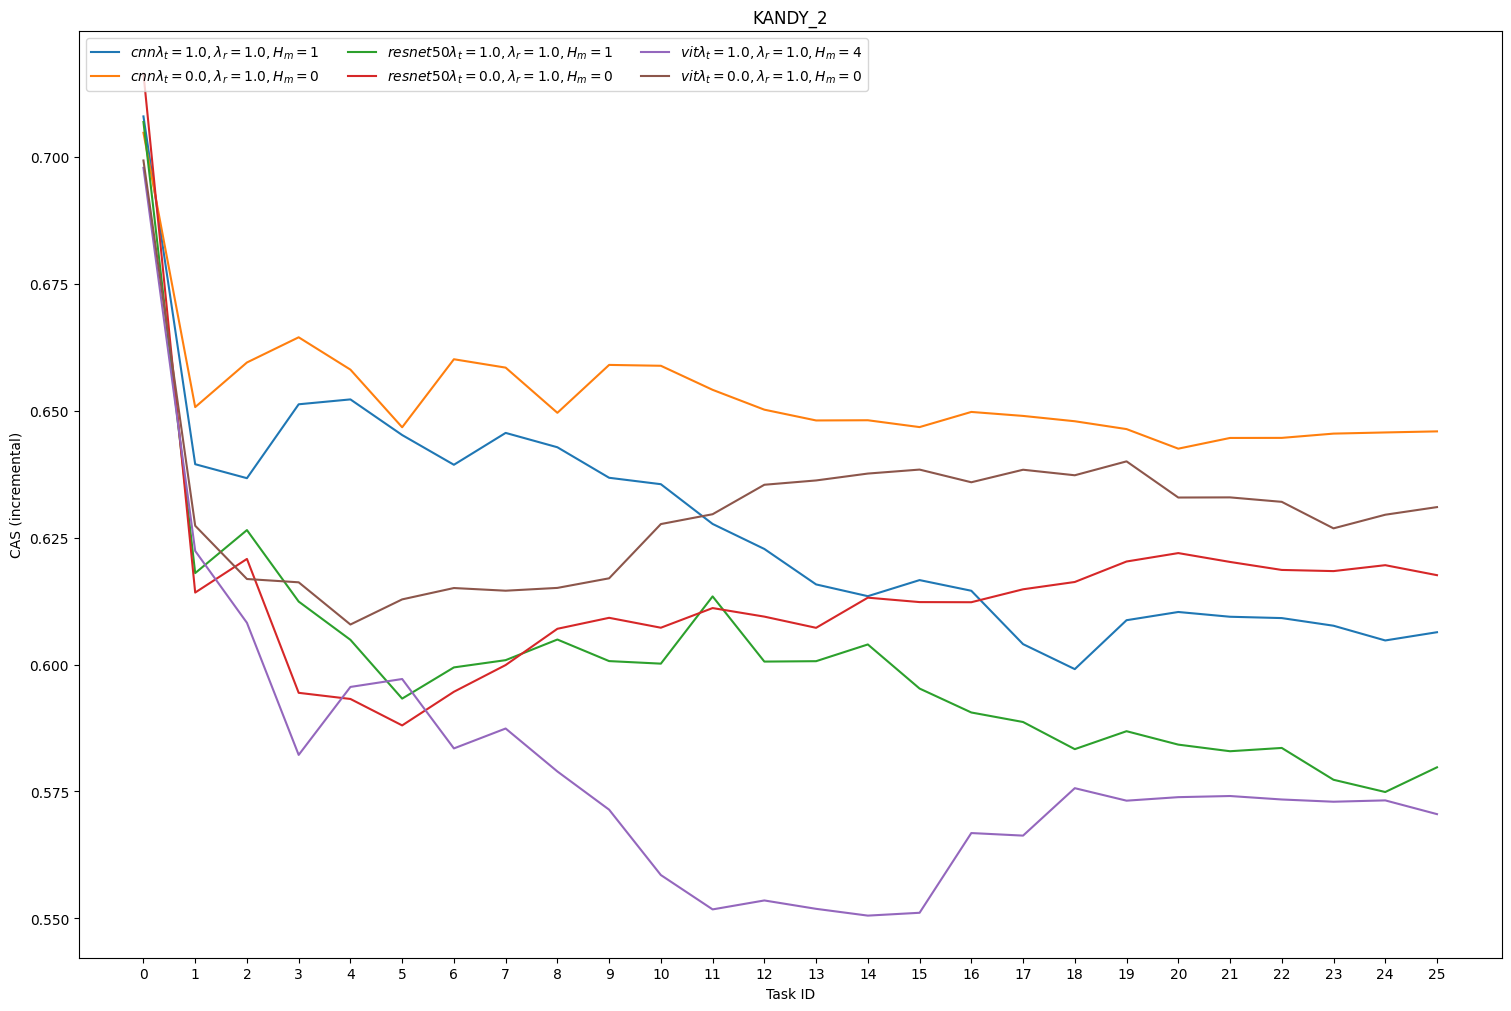

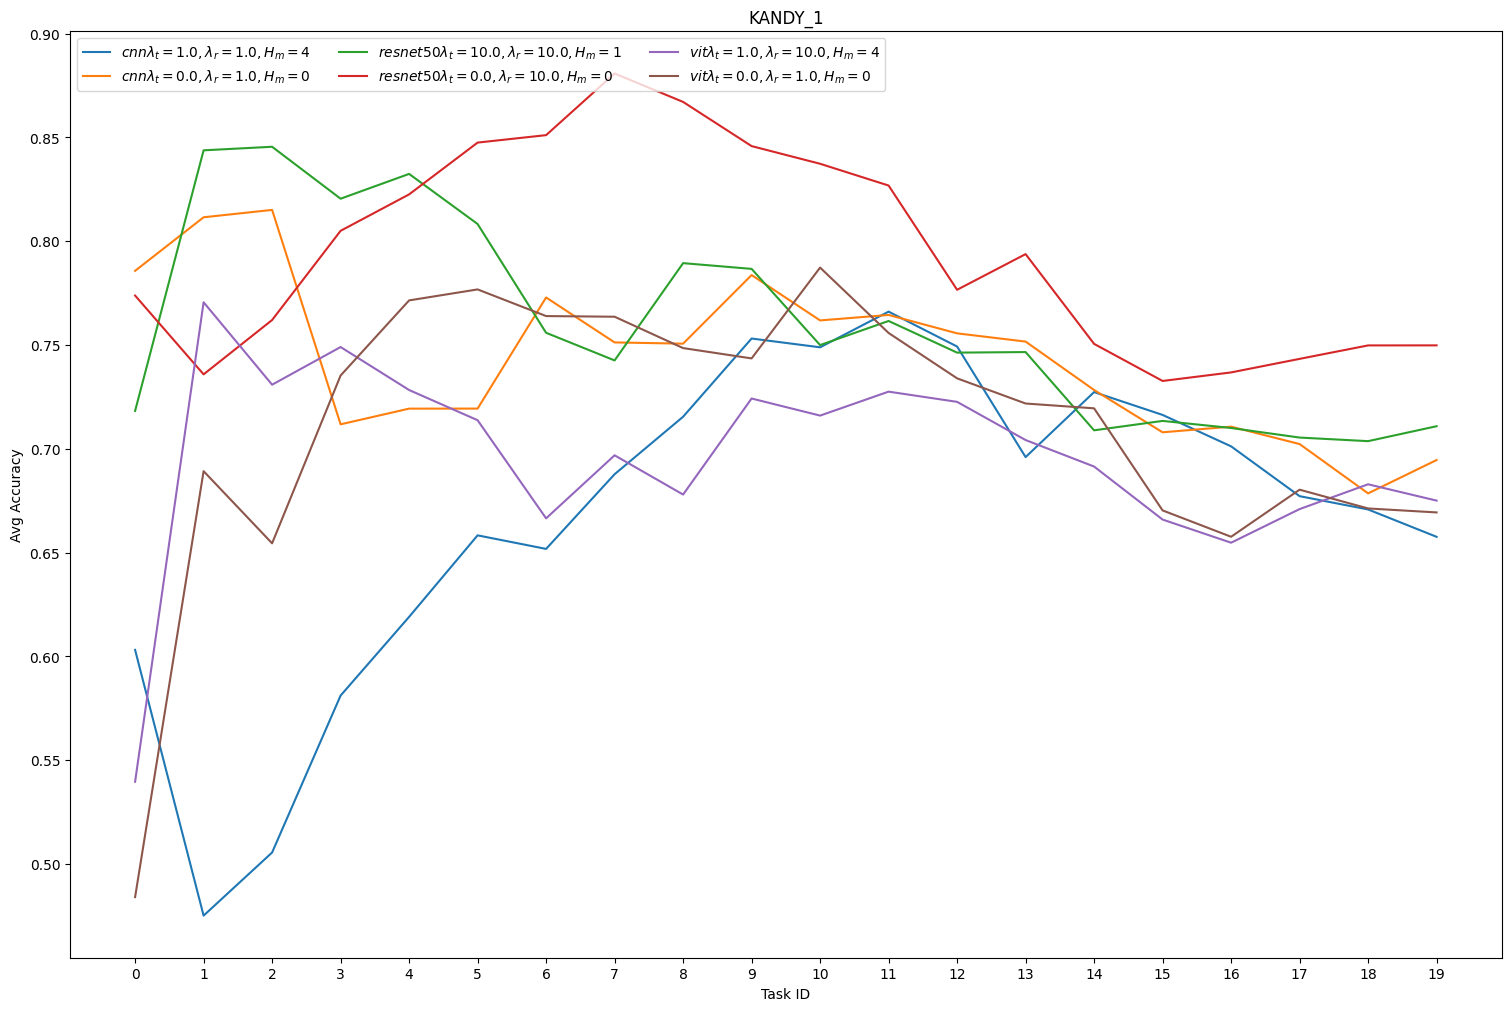

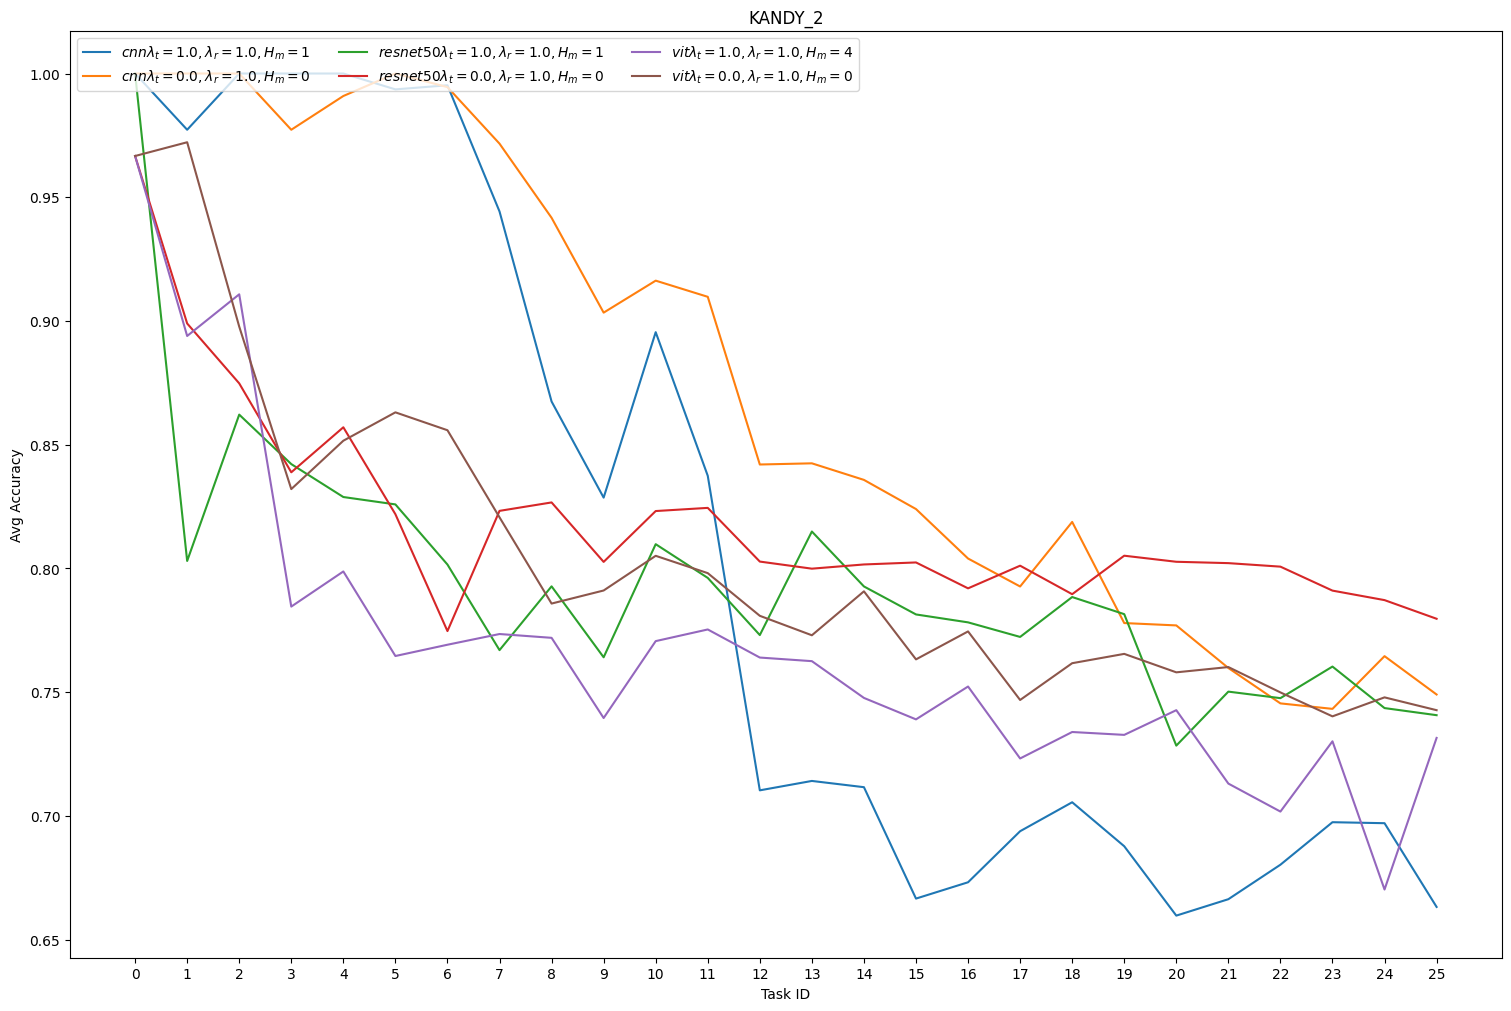

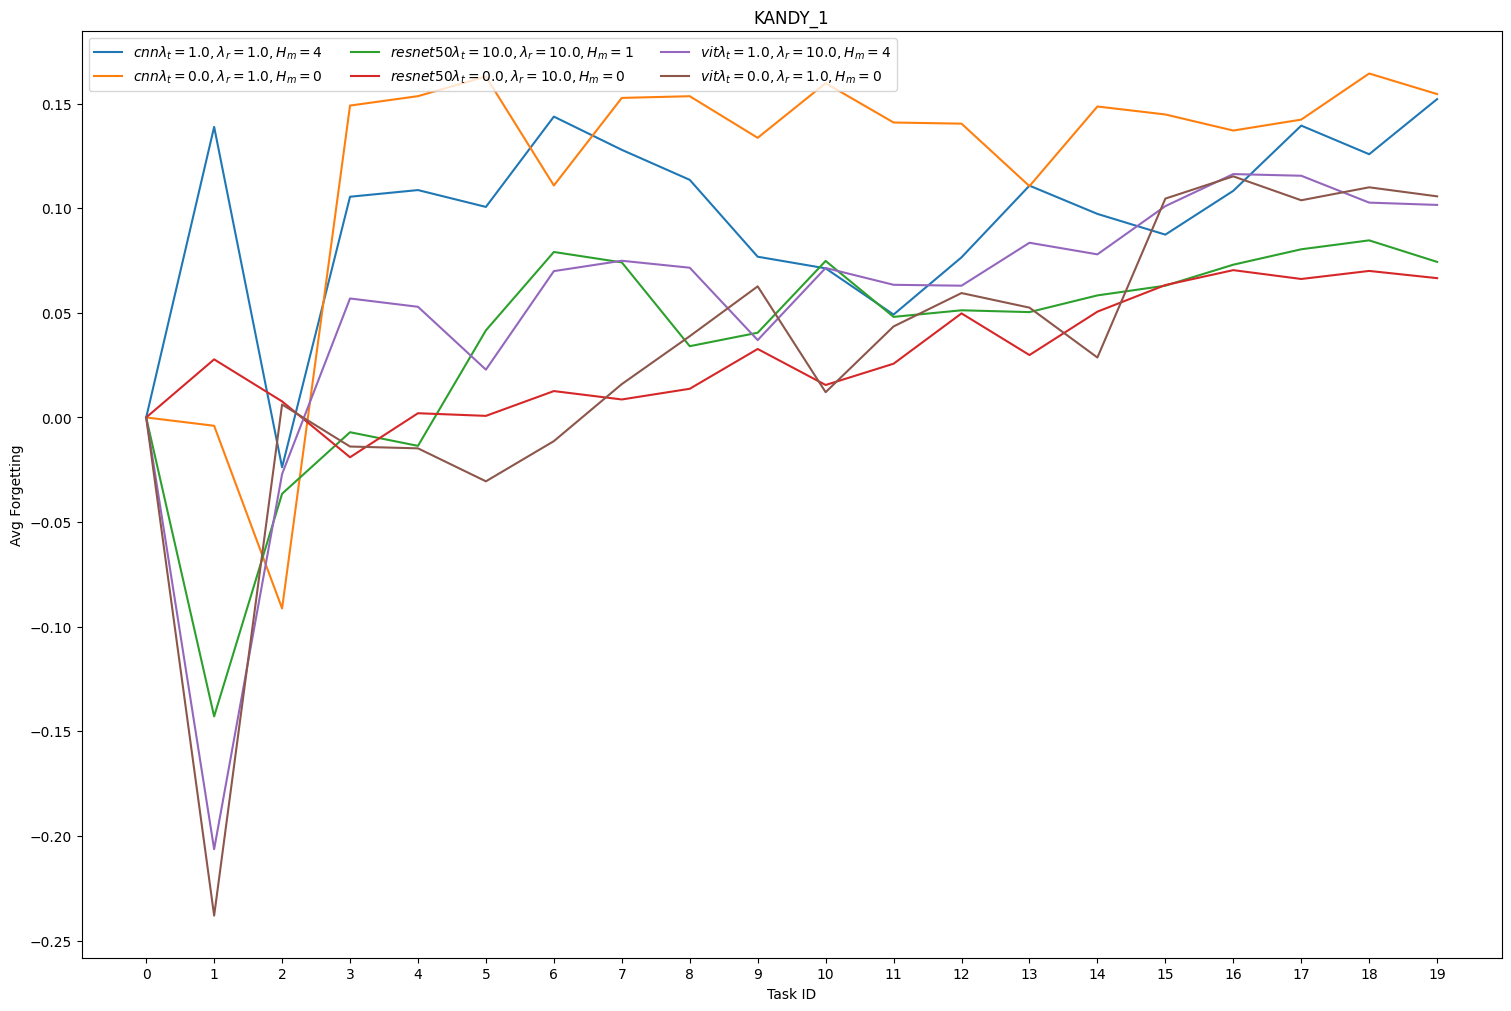

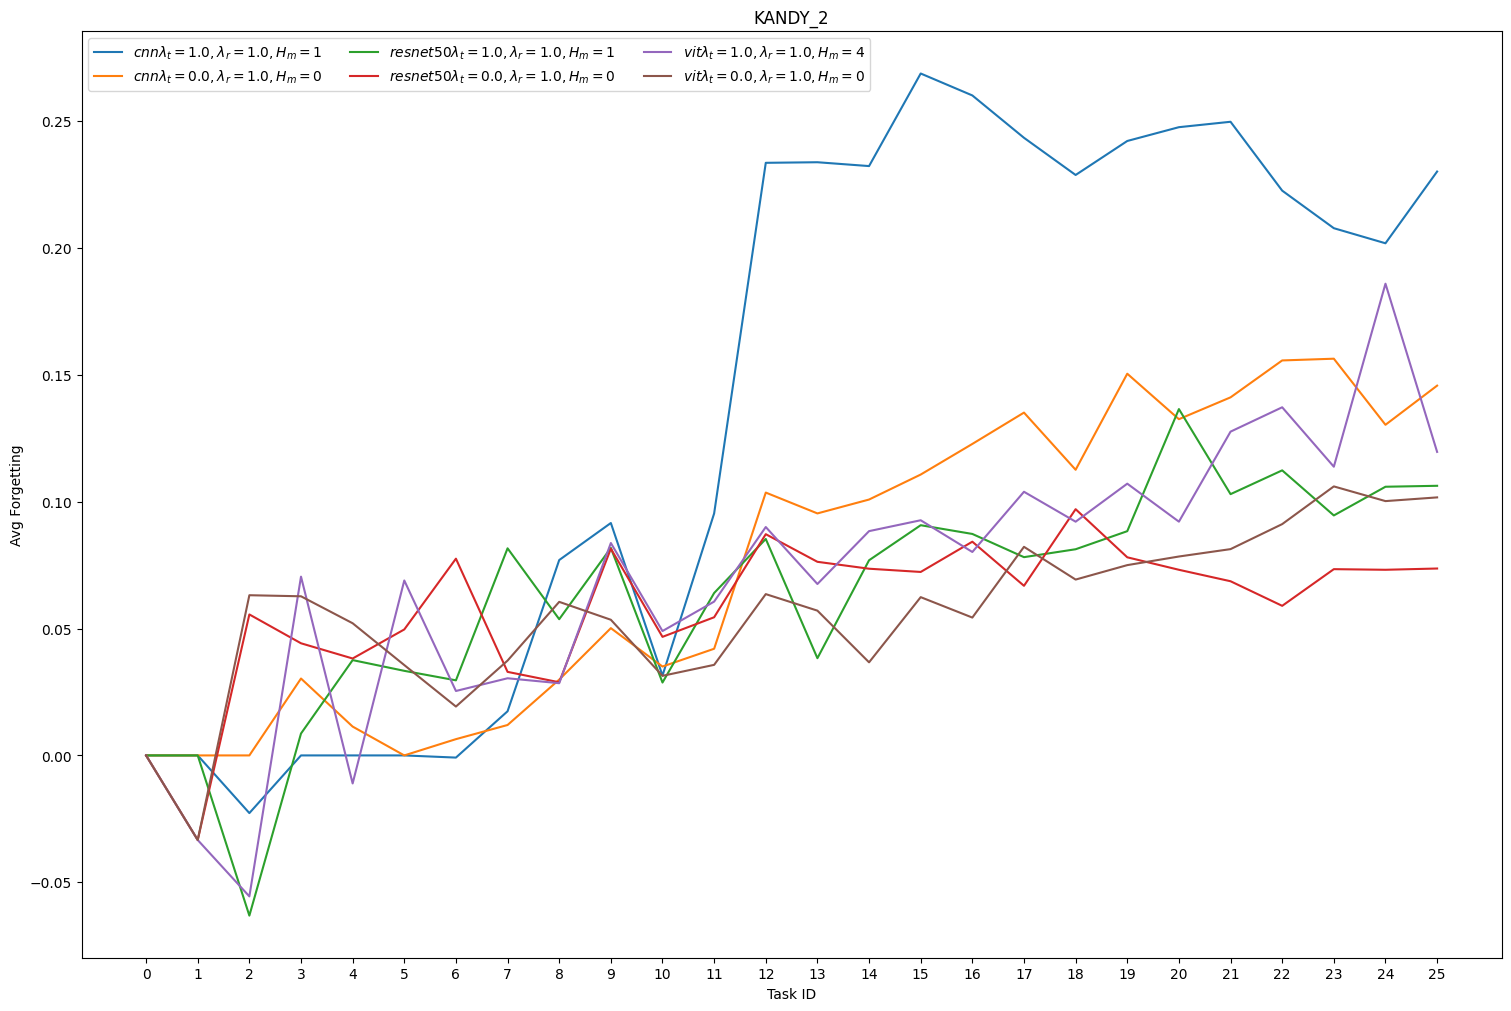

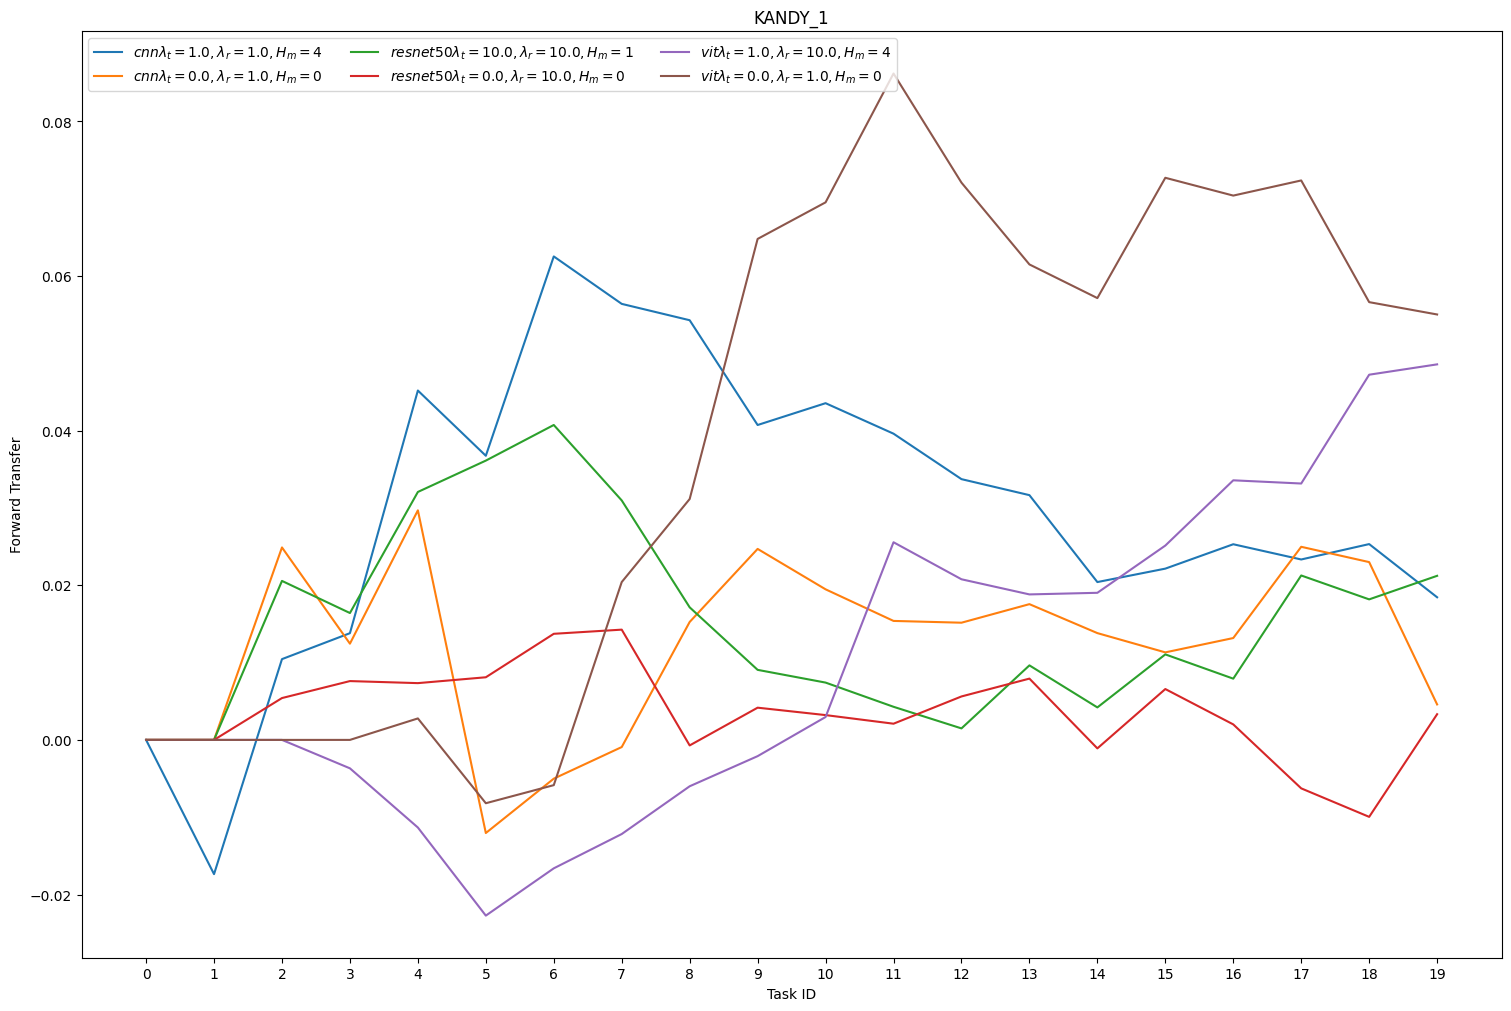

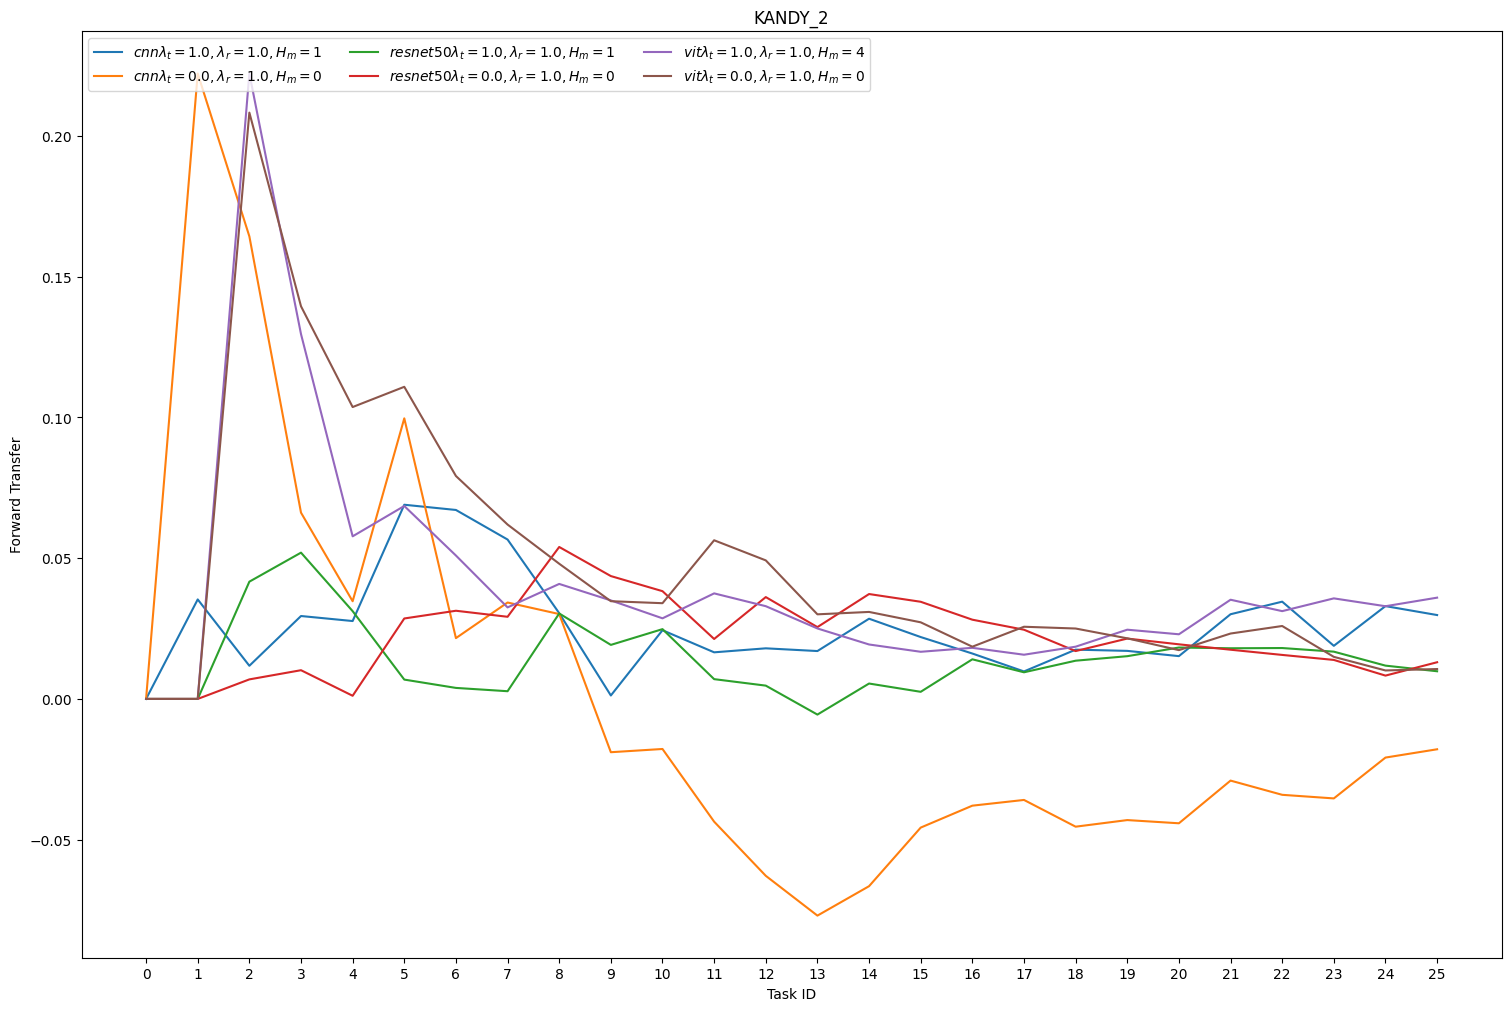

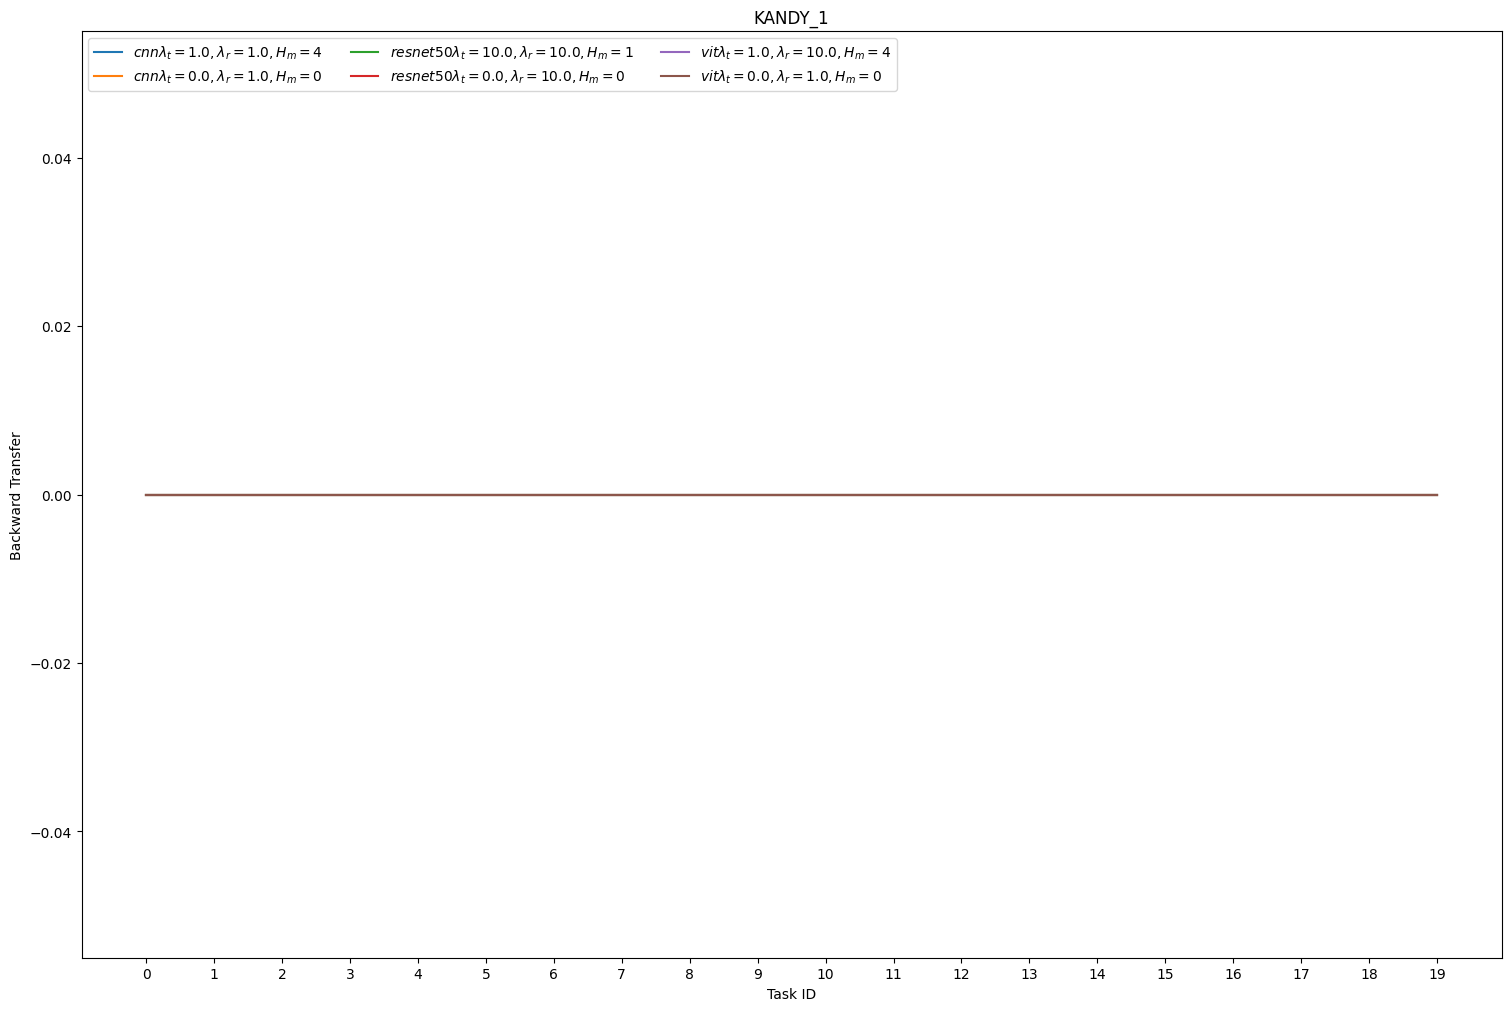

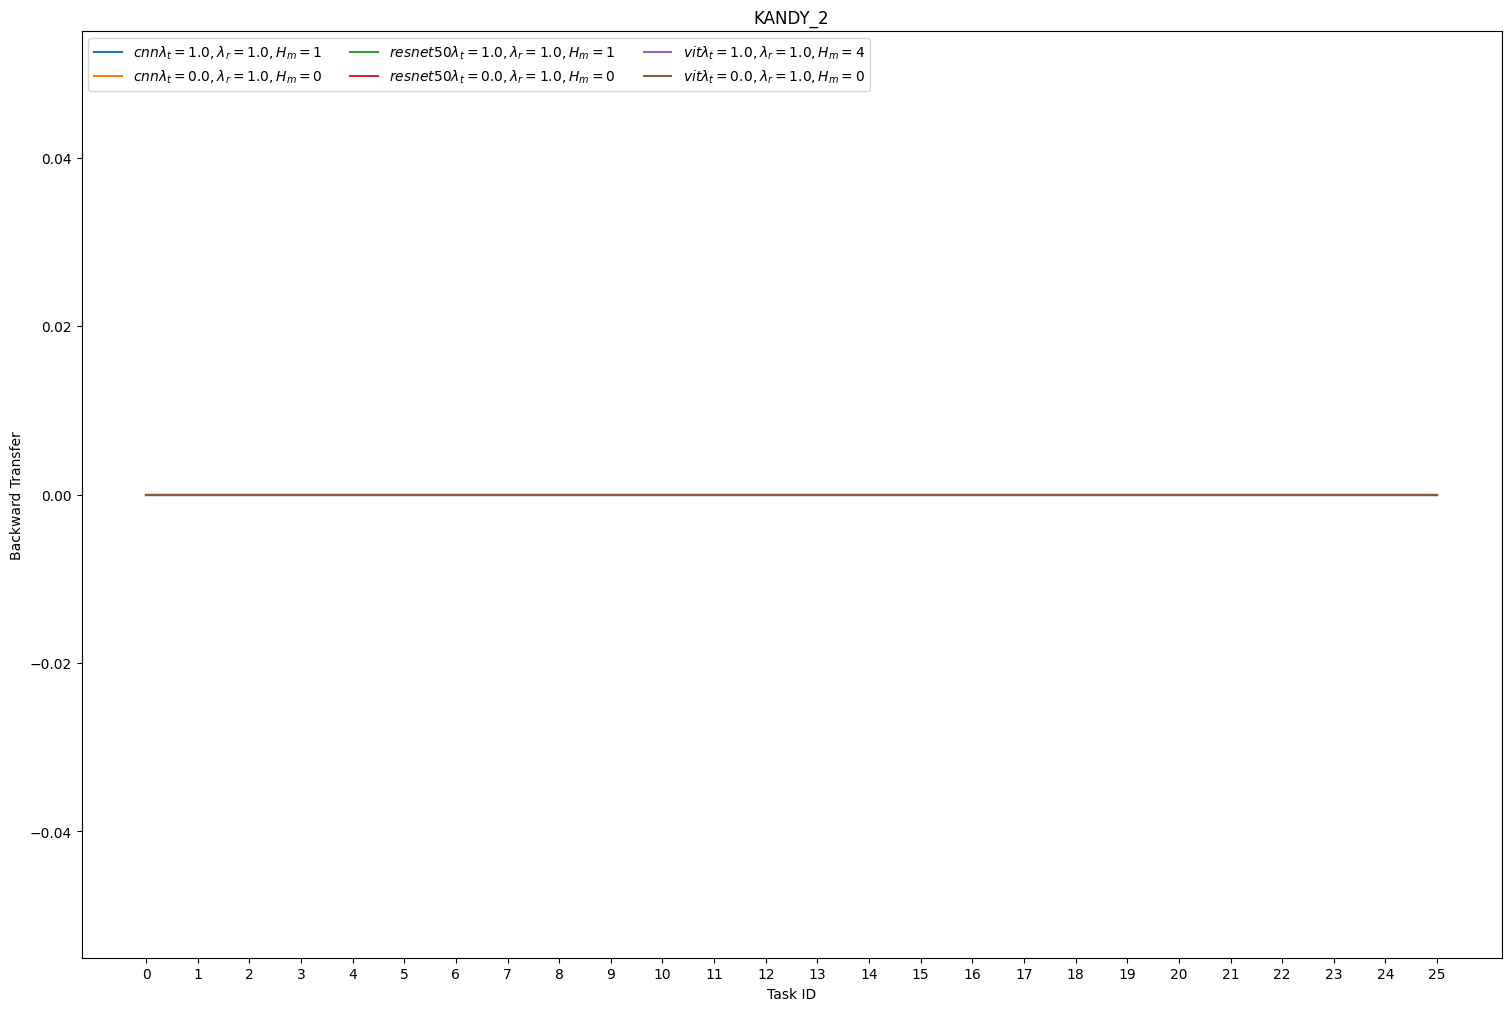

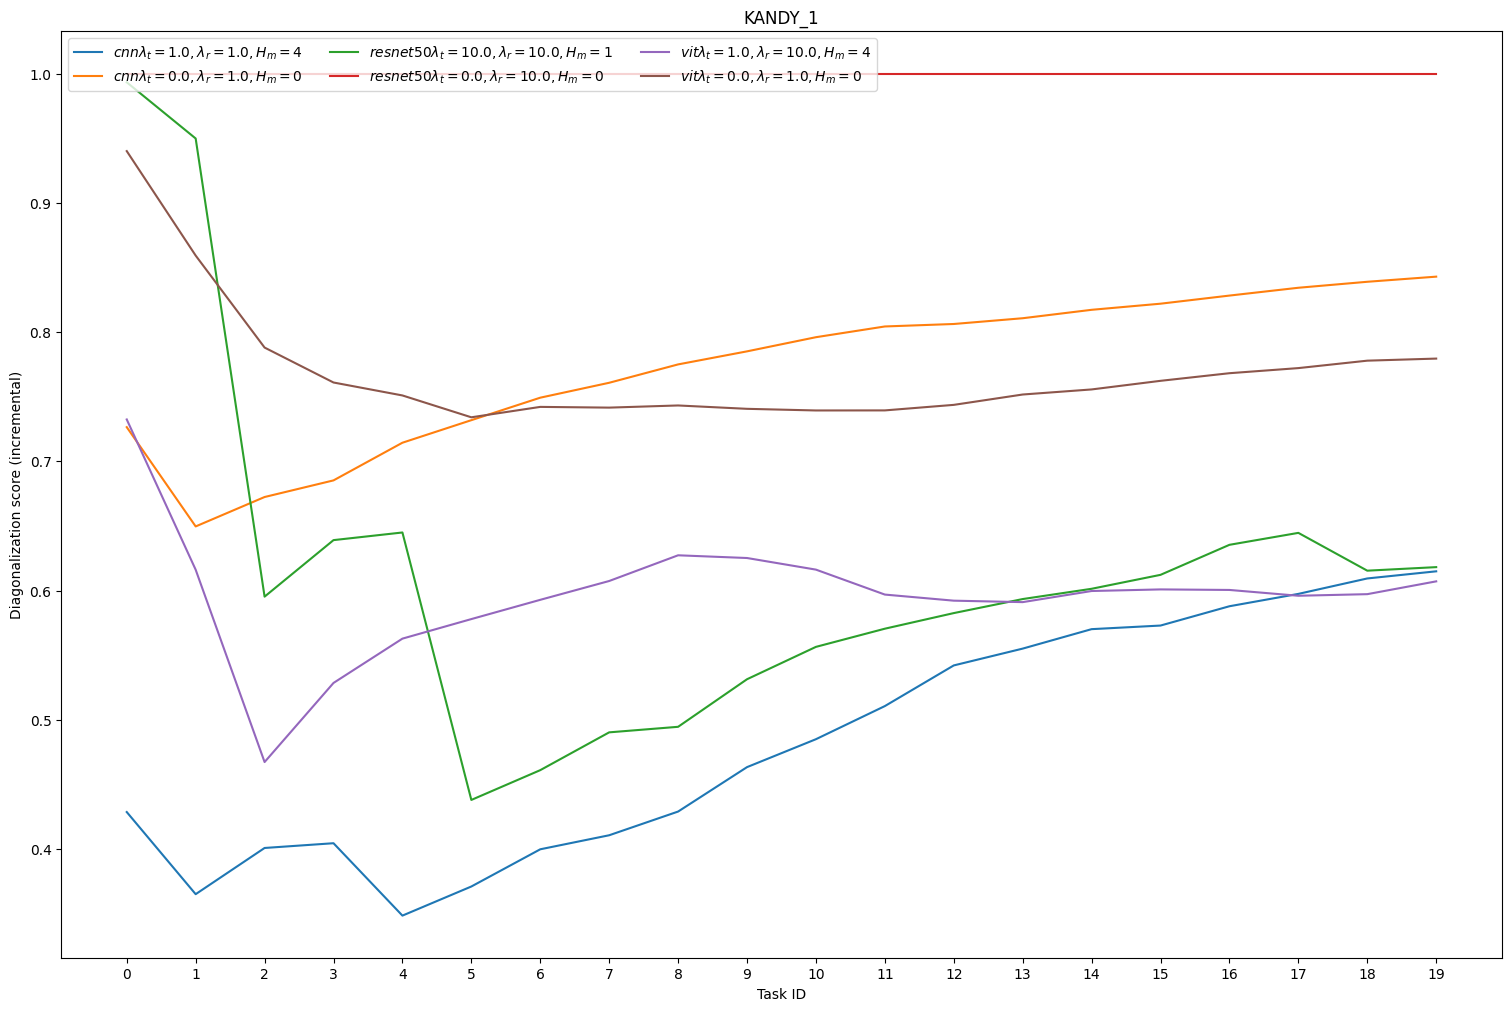

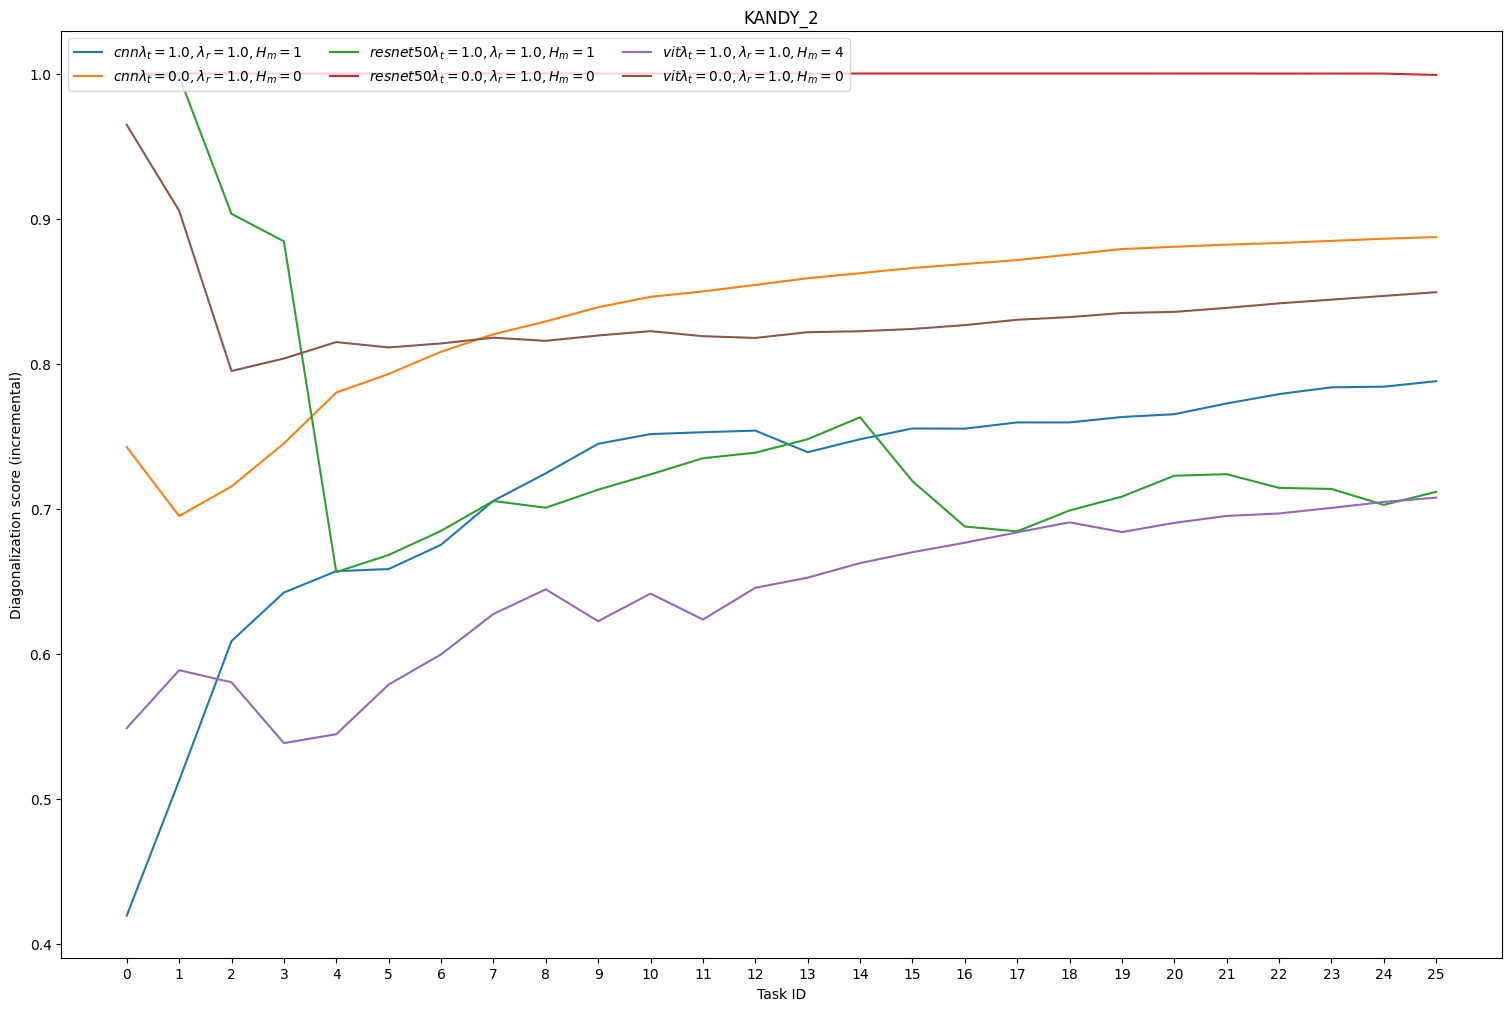

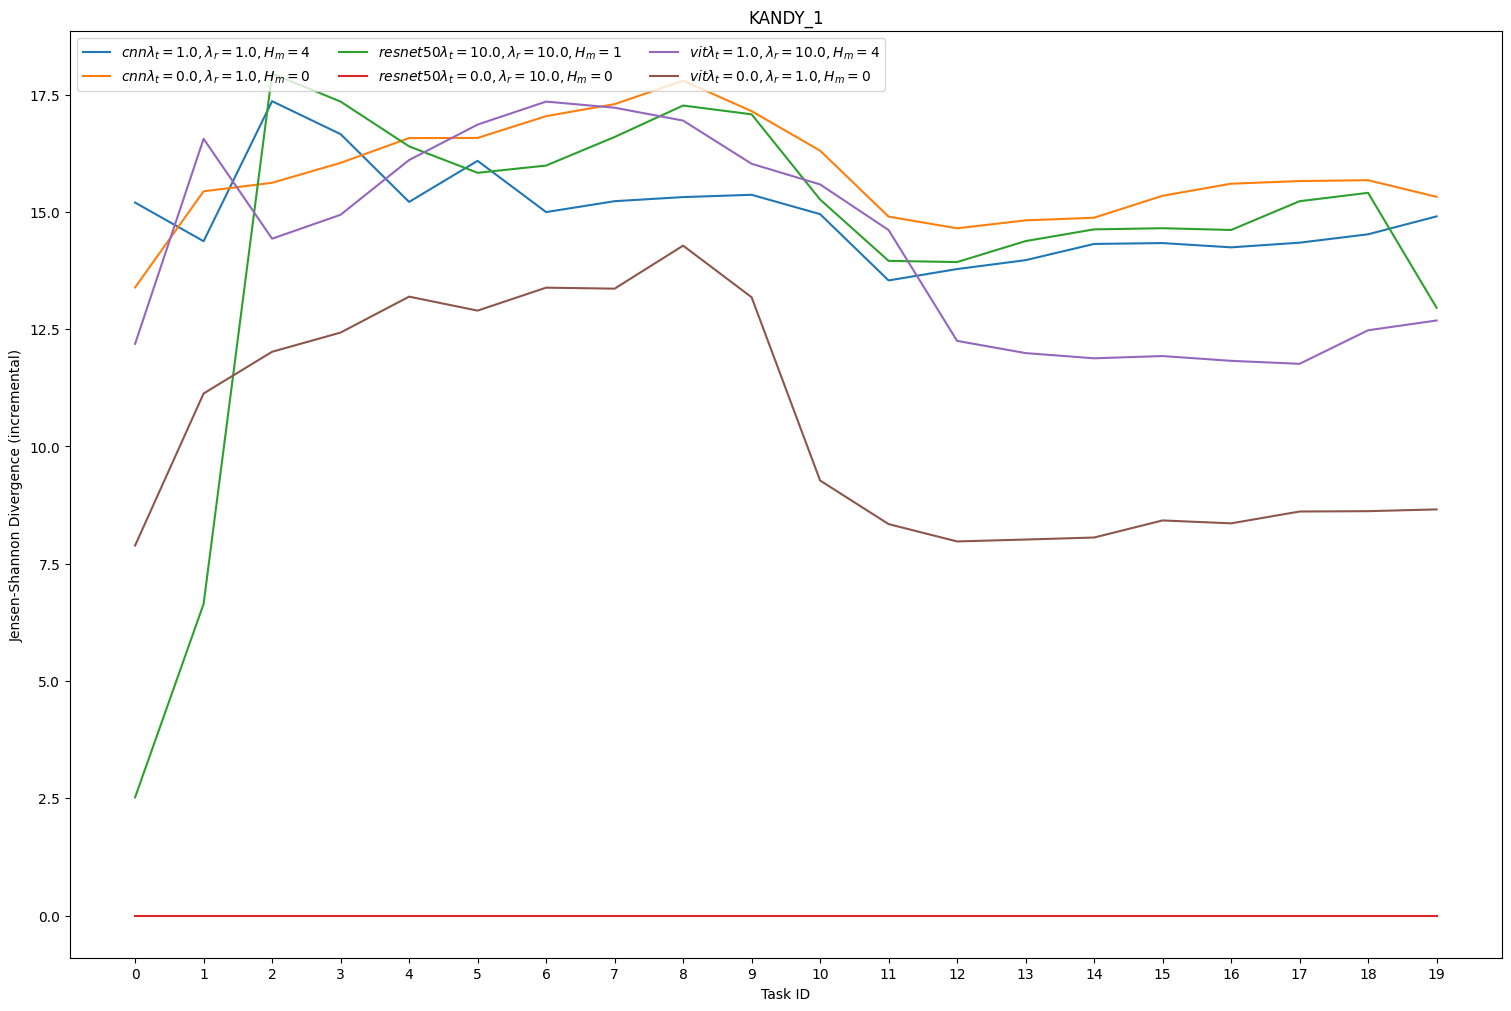

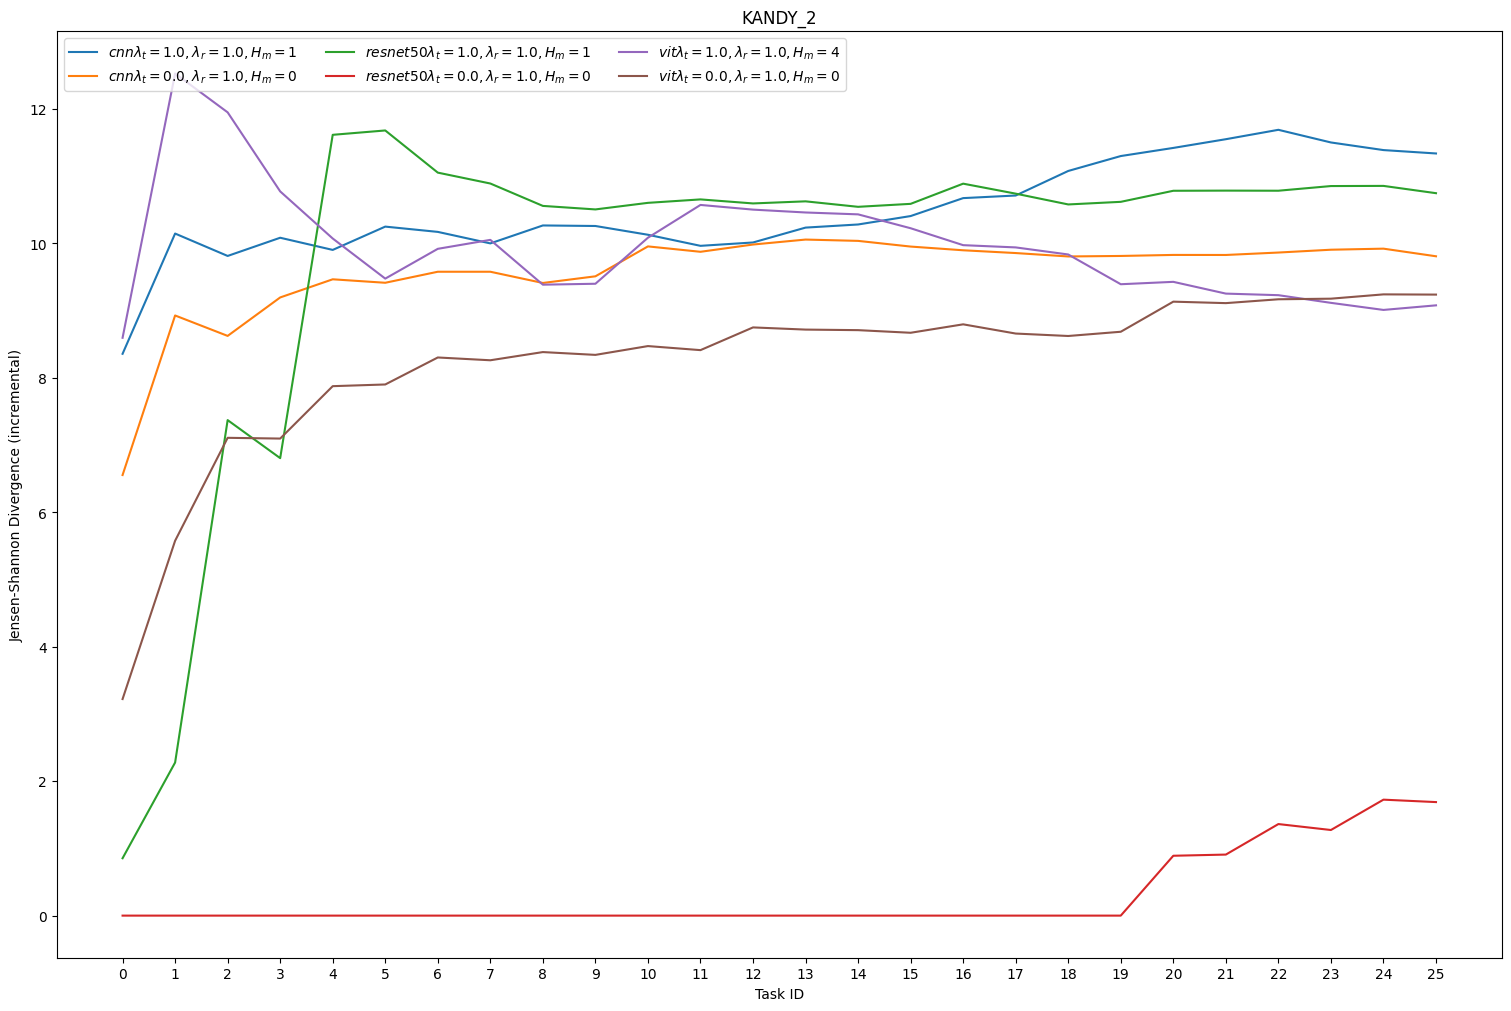

In [7]:
# LINEPLOTS

metrics_to_plot = {"TAS (incremental)": "tas_extended-test", "CAS (incremental)": "cas_extended-test", 
                   "Avg Accuracy": "avg_accuracy-test", "Avg Forgetting": "avg_forgetting-test",
                  "Forward Transfer": "forward_transfer-test", "Backward Transfer": "backward_transfer-test",
                  "Diagonalization score (incremental)": "diagonalized_extended-test", "Jensen-Shannon Divergence (incremental)": "jsd_extended-test"}

for metric_name, metric_key in metrics_to_plot.items():
    for dataset, v in best_models.items():
        task_ids = None
        values = {}
        for model, v2 in v.items():
            for triplet, v3 in v2["continual_task"].items():
                m = models[v3]
                name = "${} \\lambda_t={},\\lambda_r={},H_m={}$".format(model.split("_")[0], m["triplet_lambda"], m["replay_lambda"], m["hamming_margin"])
                
                values[name] = []
                
                if task_ids is None:
                    task_ids = list(range(len(m[metric_key])))
                for i in task_ids:
                    values[name].append(m[metric_key].iloc[i])
    
        fig, ax = plt.subplots(figsize=(15,10), layout='constrained')
        
        for n, val in values.items():
            rects = ax.plot(val, label=n)
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Task ID')
        ax.set_title(dataset)
        ax.set_xticks(task_ids)
        ax.legend(loc='upper left', ncols=3)
        
        plt.show()
